In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime
import copy
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# %matploblib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'
# sat_file = f'{iclassdir}stats/stats_goes16_20181015.0000_20190303.0000.nc'
# sonde_file = f'{iclassdir}stats/interpsonde_celltrack_20181015.0000_20190303.0000.nc'

iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
stats_file3d = f'{statsdir}/stats_3d_ppi_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/'
# # statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_mpgridded_celltracking.c1/stats/'
# stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{statsdir}/stats_3d_ppi_20181015.0000_20190303.0000.nc'
# sat_file = f'{statsdir}/stats_goes16_dilated_20181015.0000_20190303.0000.nc'
# # sat_file = f'{statsdir}/stats_goes16_undilated_20181015.0000_20190303.0000.nc'
# sonde_file = f'{statsdir}/interpsonde_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats/celltrack_environment_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats_mpgrid/celltrack_environment_stats/'
figdir_jointhist = f'{figdir}jointhist/'
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_jointhist, exist_ok=True)
print(figdir)

/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/


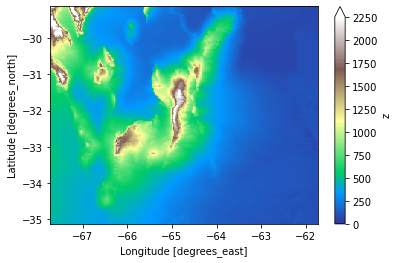

In [4]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [5]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6895

In [6]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [7]:
# Read 3D data
stats3d = xr.open_dataset(stats_file3d)
stats3d.dims['tracks']

6895

In [8]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [9]:
# Combine 2D and 3D datasets by coordinates
stats = xr.combine_by_coords([stats2d, stats3d, sat, sonde], combine_attrs='override')
stats.load()

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6895, z: 45)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int32 0 1 2 3 4 5 ... 54 55 56 57 58 59
  * z                            (z) float64 0.0 500.0 ... 2.15e+04 2.2e+04
Data variables: (12/280)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    max_zdr                      (tracks, times, z) float32 6.446 6.446 ... nan
    max_kdp                      (tracks, times, z) float32 0.0 0.0 ... nan nan
    max_rainrate                 (tracks, times, z) float32 0.0 0.0 ... nan nan
    max_Dm                       (tracks, times, z) float32 3.687 3.687 ... nan
    max_lwc                      (tracks, times, z) float32 0.0 0.0 ... nan nan
    volrain                      (tracks, times, z) float32 0.0 0.0 ... nan nan
Attributes:
    title:              InterpSonde parameters matched to tracked cells
    Institution:        Pacific Northwest National Laboratoy
    Contact:            Zhe Feng, zhe.feng@pnnl.gov
    Created_on:         Mon Apr 12 12:54:27 2021
    source_track_file:  /global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/t...
    source_sonde_file:  /global/project/projectdirs/m1657/jmarquis/Environmen...
    startdate:          20181015.0000
    enddate:            20190303.0000

In [10]:
tracks = stats['tracks']
times = stats['times']
height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6895
Number of valid tracks: 6887


6887

In [11]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [12]:
# cape = stats.cape.sel(reltime=0)
# cape = cape.where(cape > 0)
# cape.plot.hist(bins=50)

In [13]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [14]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4528
Number of merge tracks: 1603
Number of split tracks: 1528


In [15]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_eth20_max = eth20.max(dim='times')

In [16]:
sonde.keys()

KeysView(<xarray.Dataset>
Dimensions:                      (reltime: 4, tracks: 6895)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
Data variables: (12/209)
    time                         (tracks, reltime) datetime64[ns] ...
    tallenough_sfc               (tracks, reltime) float32 ...
    CAPE_sfc                     (tracks, reltime) float32 ...
    CIN_NA_sfc                   (tracks, reltime) float32 ...
    CIN_NA_fract_sfc             (tracks, reltime) float32 ...
    CIN_IB_sfc                   (tracks, reltime) float32 ...
    ...                           ...
    rvap_diff_grndtoACBL_mu      (tracks, reltime) float32 ...
    rvap_diff_grndtoACBL_sfc     (tracks, reltime) float32 ...
    RH_mean_ACBL                 (tracks, reltime) float32 ...
    RH_min_ACBL                  (tracks, reltime) float32 ...
    DD_mean_ACBL                 (tracks, reltime) float32 ..

In [17]:
# Choose 0 hour relative time, and filter negative parcel values
cape = stats['CAPE_mu'].where(stats['CAPE_mu'] > 0).sel(reltime=0)
cin = stats['CIN_IB_mu'].where(stats['CIN_IB_mu'] >= 0).sel(reltime=0)
lcl_z = stats['LCL_height_mu'].where(stats['LCL_height_mu'] >= 0).sel(reltime=0) / 1000
lfc_z = stats['LFC_height_mu'].where(stats['LFC_height_mu'] >= 0).sel(reltime=0) / 1000
lnb_z = stats['EL_height_mu'].where(stats['EL_height_mu'] >= 0).sel(reltime=0) / 1000
lpl_z = stats['initial_ht_parcel_mu'].where(stats['initial_ht_parcel_mu'] >= 0).sel(reltime=0) / 1000
q850p = stats['rvap_850mb'].sel(reltime=0)
q700p = stats['rvap_700mb'].sel(reltime=0)
rh700p = stats['rh_700mb'].sel(reltime=0)
rh500p = stats['rh_500mb'].sel(reltime=0)
shear6mag = stats['shear_mag_bulk_0to6km'].sel(reltime=0)
shear3mag = stats['shear_mag_bulk_0to3km'].sel(reltime=0)
u700p = stats['U_700mb'].sel(reltime=0)
v700p = stats['V_700mb'].sel(reltime=0)
u850p = stats['U_850mb'].sel(reltime=0)
v850p = stats['V_850mb'].sel(reltime=0)

In [18]:
def quantiles3d_by2cond(in_var, x_cond_var, x_cond_range, y_cond_var, y_cond_range, 
                        loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles):
    nbins_x = len(x_cond_range)-1
    nbins_y = len(y_cond_range)-1
    nz = in_var.sizes['z']
    npts = len(quantiles)
    out_var_time0_pts = np.full((npts, nz, nbins_y, nbins_x), np.nan, dtype=float)
    out_var_max_pts = np.full((npts, nz, nbins_y, nbins_x), np.nan, dtype=float)
    nsamples = np.full((nbins_y, nbins_x), 0, dtype=np.int32)
#     print(nsamples.shape)
    # Loop over two conditional variable bins
    for xbin in range(nbins_x):
        for ybin in range(nbins_y):
#             print(xbin, ybin)
            in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
                                       (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
                                       (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]) &
                                       (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)
            # Replace NaN with a large negative value to take into account decreasing sample with height
            # NaN is excluded in quantile calculations which biases the sampling with increasing height
            fillval = -99
            in_var_cond = in_var_cond.where(~np.isnan(in_var_cond), other=fillval)
            # Number of samples
            nsamples[ybin, xbin] = in_var_cond.sizes['tracks']
            # Initiation and lifetime max profile quantiles
            out_var_time0_pts[:, :, ybin, xbin] = in_var_cond.isel(times=0).quantile(quantiles, dim='tracks', skipna=True).values
            out_var_max_pts[:, :, ybin, xbin] = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True).values
    return (nsamples, out_var_time0_pts, out_var_max_pts)

In [86]:
# Find tracks initiation east of SDC during the day (12PM - 8PM)
# LT = UTC + 3
# Approximate longitude of SDC ridge
# lon_SDC = -64.9
# lon_eSDC = [-64.9, -63.]
lon_SDC = -65
lon_eSDC = [-65, -63]
# Day/night hour range in UTC
# UTChour_day = [15,22]
# UTChour_night = [0,8]

# Find equal sample number bin values by quantiles
# quantile_bins = np.arange(0,1.01,0.2).tolist()
quantile_bins = [0,0.33,0.66,1]
# cape_qcut, cape_bins = pd.qcut(cape, 5, retbins=True)
cape_qcut, cape_bins = pd.qcut(cape, quantile_bins, retbins=True)
shear6mag_qcut, shear6mag_bins = pd.qcut(shear6mag, quantile_bins, retbins=True)
cape_bins = np.array(cape_bins)
shear6mag_bins = np.array(shear6mag_bins)

# cape_range = [50,400,900,4000]
# shear6mag_range = [0,20,28,50]
cape_bins = [50,400,1000,8000]
shear6mag_bins = [0,20,27,50]
cape_range = cape_bins
shear6mag_range = shear6mag_bins

print(f'CAPE bins: {cape_bins}')
print(f'Shear0-6 bins: {shear6mag_bins}')

CAPE bins: [50, 400, 1000, 8000]
Shear0-6 bins: [0, 20, 27, 50]


In [87]:
quantiles_3d = [0.25,0.5,0.75,0.9]

nsamples_capeshear6mag, max_dbz_prof0_capeshear6mag_pts, max_dbz_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_reflectivity, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

nsamples_capeshear6mag, dbz20_area_prof0_capeshear6mag_pts, dbz20_area_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

nsamples_capeshear6mag, dbz30_area_prof0_capeshear6mag_pts, dbz30_area_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

nsamples_capeshear6mag, max_zdr_prof0_capeshear6mag_pts, max_zdr_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_zdr, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

nsamples_capeshear6mag, max_kdp_prof0_capeshear6mag_pts, max_kdp_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_kdp, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

nsamples_capeshear6mag, max_rainrate_prof0_capeshear6mag_pts, max_rainrate_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_rainrate, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

nsamples_capeshear6mag, max_Dm_prof0_capeshear6mag_pts, max_Dm_maxprof_capeshear6mag_pts = quantiles3d_by2cond(stats.max_Dm, cape, cape_range, shear6mag, shear6mag_range,
                                                                                             start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_3d)

In [88]:
idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()

# Replace heights where 25th percentile area = 0 & 75th percentile area != 0 with a very small positive value to avoid -inf when applying log10
# This is only for plotting purpose

for ix in range(len(cape_bins)-1):
    for iy in range(len(shear6mag_bins)-1):
        # Find heights where 25pth percentile area is 0 but 75th percentile area is > 0, then replace 0 with a small positive value
        idx = np.where((dbz20_area_prof0_capeshear6mag_pts[idx75,:,iy,ix] > 0) & (dbz20_area_prof0_capeshear6mag_pts[idx25,:,iy,ix] == 0))
        dbz20_area_prof0_capeshear6mag_pts[idx25,idx,iy,ix] = 1e-9
        idx = np.where((dbz30_area_prof0_capeshear6mag_pts[idx75,:,iy,ix] > 0) & (dbz30_area_prof0_capeshear6mag_pts[idx25,:,iy,ix] == 0))
        dbz30_area_prof0_capeshear6mag_pts[idx25,idx,iy,ix] = 1e-9
        
        idx = np.where((dbz20_area_maxprof_capeshear6mag_pts[idx75,:,iy,ix] > 0) & (dbz20_area_maxprof_capeshear6mag_pts[idx25,:,iy,ix] == 0))
        dbz20_area_maxprof_capeshear6mag_pts[idx25,idx,iy,ix] = 1e-9
        idx = np.where((dbz30_area_maxprof_capeshear6mag_pts[idx75,:,iy,ix] > 0) & (dbz30_area_maxprof_capeshear6mag_pts[idx25,:,iy,ix] == 0))
        dbz30_area_maxprof_capeshear6mag_pts[idx25,idx,iy,ix] = 1e-9

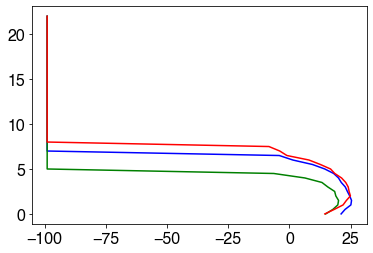

In [89]:
qntl = 0.25
idx = np.where(np.array(quantiles_3d) == qntl)[0].item()
plt.plot(max_dbz_prof0_capeshear6mag_pts[idx,:,0,0], height, color='b')
plt.plot(max_dbz_prof0_capeshear6mag_pts[idx,:,1,1], height, color='g')
plt.plot(max_dbz_prof0_capeshear6mag_pts[idx,:,2,2], height, color='r')

In [90]:
def plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, legend2, figname):
    mpl.rcParams['font.size'] = 16
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)

    ylims = [1, 15]
    colors = {'low':'blue', 'medium':'green', 'high':'crimson'}
    
    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            ax.plot(data1_avg[row][col], height, color=colors['low'], lw=5, label=legends[0])
            ax.plot(data2_avg[row][col], height, color=colors['medium'], lw=5, label=legends[1])
            ax.plot(data3_avg[row][col], height, color=colors['high'], lw=5, label=legends[2])
            ax.fill_betweenx(height, data1_pts[row][col][0], data1_pts[row][col][1], color=colors['low'], edgecolor=None, alpha=0.25)
            ax.fill_betweenx(height, data2_pts[row][col][0], data2_pts[row][col][1], color=colors['medium'], edgecolor=None, alpha=0.25)
            ax.fill_betweenx(height, data3_pts[row][col][0], data3_pts[row][col][1], color=colors['high'], edgecolor=None, alpha=0.25)
            ax.grid(ls='--')
            ax.set_xlim(xlims[row][col][0], xlims[row][col][1])
            ax.set_ylim(ylims[0], ylims[1])
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel('Height (km)')
            ax.set_title(titles1[row][col], loc='left')
            ax.set_title(titles2, loc='right', fontsize=14)
            ax.legend(loc='upper right', fontsize=13)
            ax.text(0.95, 0.7, legend2, ha='right', transform=ax.transAxes, fontsize=13)
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    return fig

<ipython-input-91-57f885f29d3c>:2: RuntimeWarning: divide by zero encountered in log10
  p25 = np.log10(dbz20_area_prof[idx25,:,0,0])
<ipython-input-91-57f885f29d3c>:3: RuntimeWarning: divide by zero encountered in log10
  p50 = np.log10(dbz20_area_prof[idx50,:,0,0])
<ipython-input-91-57f885f29d3c>:4: RuntimeWarning: divide by zero encountered in log10
  p75 = np.log10(dbz20_area_prof[idx75,:,0,0])


(0.0, 10.0)

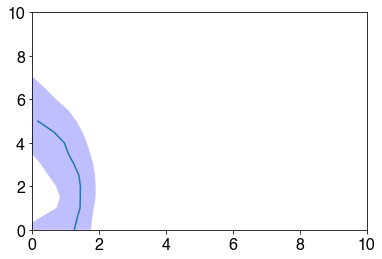

In [91]:
dbz20_area_prof = np.copy(dbz20_area_prof0_capeshear6mag_pts)
p25 = np.log10(dbz20_area_prof[idx25,:,0,0])
p50 = np.log10(dbz20_area_prof[idx50,:,0,0])
p75 = np.log10(dbz20_area_prof[idx75,:,0,0])
plt.plot(p50, height)
plt.fill_betweenx(height, p25, p75, color='b', edgecolor=None, alpha=0.25)
plt.ylim(0,10)
plt.xlim(0,10)

<ipython-input-132-fef3b650767c>:5: RuntimeWarning: divide by zero encountered in log10
  data1_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,0], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,0]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,0]],
<ipython-input-132-fef3b650767c>:7: RuntimeWarning: divide by zero encountered in log10
  data2_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,1], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,1]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,1]],
<ipython-input-132-fef3b650767c>:9: RuntimeWarning: divide by zero encountered in log10
  data3_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,2], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,2]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,2]],
<ipython-input-132-fef3b650767c>:12: RuntimeWarning: divide by zero encountered in log10
  (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,0]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:

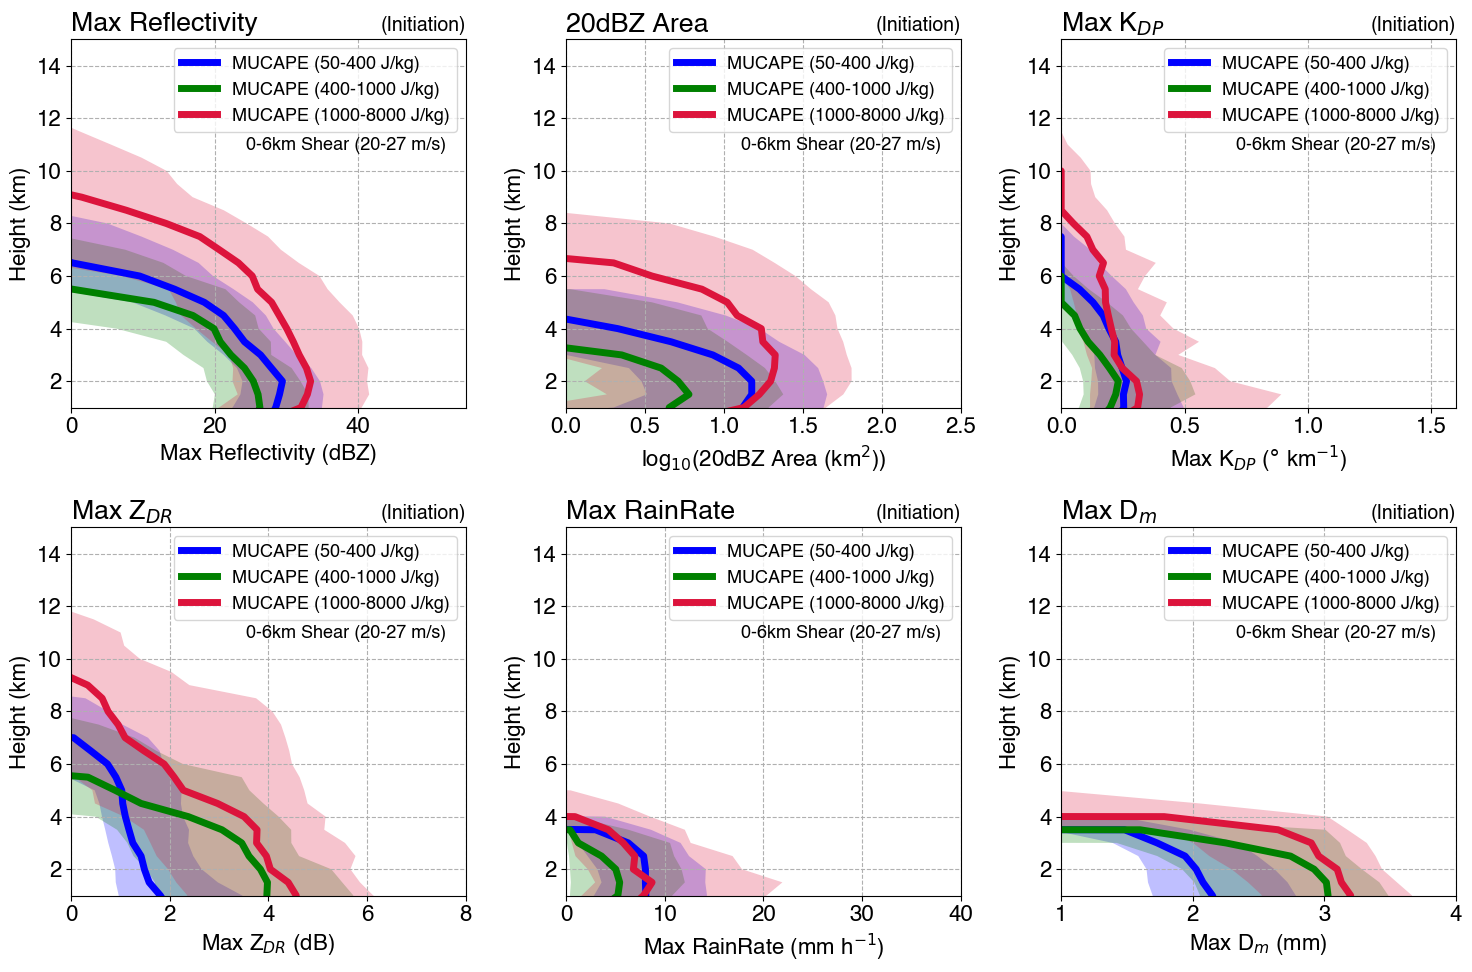

In [132]:
idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()
ybin = 1  # shear bin value [range: 0-2]
data1_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,0], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,0]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,0]],
             [max_zdr_prof0_capeshear6mag_pts[idx50,:,ybin,0], max_rainrate_prof0_capeshear6mag_pts[idx50,:,ybin,0], max_Dm_prof0_capeshear6mag_pts[idx50,:,ybin,0]]]
data2_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,1], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,1]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,1]],
             [max_zdr_prof0_capeshear6mag_pts[idx50,:,ybin,1], max_rainrate_prof0_capeshear6mag_pts[idx50,:,ybin,1], max_Dm_prof0_capeshear6mag_pts[idx50,:,ybin,1]]]
data3_avg = [[max_dbz_prof0_capeshear6mag_pts[idx50,:,ybin,2], np.log10(dbz20_area_prof0_capeshear6mag_pts[idx50,:,ybin,2]), max_kdp_prof0_capeshear6mag_pts[idx50,:,ybin,2]],
             [max_zdr_prof0_capeshear6mag_pts[idx50,:,ybin,2], max_rainrate_prof0_capeshear6mag_pts[idx50,:,ybin,2], max_Dm_prof0_capeshear6mag_pts[idx50,:,ybin,2]]]
data1_pts = [[(max_dbz_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_dbz_prof0_capeshear6mag_pts[idx75,:,ybin,0]),
              (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,0]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:,ybin,0])),
              (max_kdp_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_kdp_prof0_capeshear6mag_pts[idx75,:,ybin,0])], 
             [(max_zdr_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_zdr_prof0_capeshear6mag_pts[idx75,:,ybin,0]),
              (max_rainrate_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_rainrate_prof0_capeshear6mag_pts[idx75,:,ybin,0]),
              (max_Dm_prof0_capeshear6mag_pts[idx25,:,ybin,0], max_Dm_prof0_capeshear6mag_pts[idx75,:,ybin,0])]]
data2_pts = [[(max_dbz_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_dbz_prof0_capeshear6mag_pts[idx75,:,ybin,1]),
              (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,1]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:,ybin,1])),
              (max_kdp_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_kdp_prof0_capeshear6mag_pts[idx75,:,ybin,1])], 
             [(max_zdr_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_zdr_prof0_capeshear6mag_pts[idx75,:,ybin,1]),
              (max_rainrate_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_rainrate_prof0_capeshear6mag_pts[idx75,:,ybin,1]),
              (max_Dm_prof0_capeshear6mag_pts[idx25,:,ybin,1], max_Dm_prof0_capeshear6mag_pts[idx75,:,ybin,1])]]
data3_pts = [[(max_dbz_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_dbz_prof0_capeshear6mag_pts[idx75,:,ybin,2]),
              (np.log10(dbz20_area_prof0_capeshear6mag_pts[idx25,:,ybin,2]), np.log10(dbz20_area_prof0_capeshear6mag_pts[idx75,:,ybin,2])),
              (max_kdp_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_kdp_prof0_capeshear6mag_pts[idx75,:,ybin,2])], 
             [(max_zdr_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_zdr_prof0_capeshear6mag_pts[idx75,:,ybin,2]),
              (max_rainrate_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_rainrate_prof0_capeshear6mag_pts[idx75,:,ybin,2]),
              (max_Dm_prof0_capeshear6mag_pts[idx25,:,ybin,2], max_Dm_prof0_capeshear6mag_pts[idx75,:,ybin,2])]]
xlims = [[(0,55), (0,2.5), (0,1.6)],
         [(0,8), (0,40), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
figname = f'{figdir}cell_initiation_profile_MUCPAE_shear0-6km_{shear6mag_range[ybin]:.0f}-{shear6mag_range[ybin+1]:.0f}ms.png'
titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
              ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
titles2 = '(Initiation)'
legends = [f'MUCAPE ({cape_range[0]:.0f}-{cape_range[1]:.0f} J/kg)', 
           f'MUCAPE ({cape_range[1]:.0f}-{cape_range[2]:.0f} J/kg)', 
           f'MUCAPE ({cape_range[2]:.0f}-{cape_range[3]:.0f} J/kg)']
legend2 = f'0-6km Shear ({shear6mag_range[ybin]:.0f}-{shear6mag_range[ybin+1]:.0f} m/s)'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, legend2, figname)

<ipython-input-134-b00eb7f7ae5a>:5: RuntimeWarning: divide by zero encountered in log10
  data1_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,0], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,0]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,0]],
<ipython-input-134-b00eb7f7ae5a>:7: RuntimeWarning: divide by zero encountered in log10
  data2_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,1], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,1]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,1]],
<ipython-input-134-b00eb7f7ae5a>:9: RuntimeWarning: divide by zero encountered in log10
  data3_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,2], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,2]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,2]],
<ipython-input-134-b00eb7f7ae5a>:12: RuntimeWarning: divide by zero encountered in log10
  (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,0]), np.log10(dbz20_area_maxprof_cap

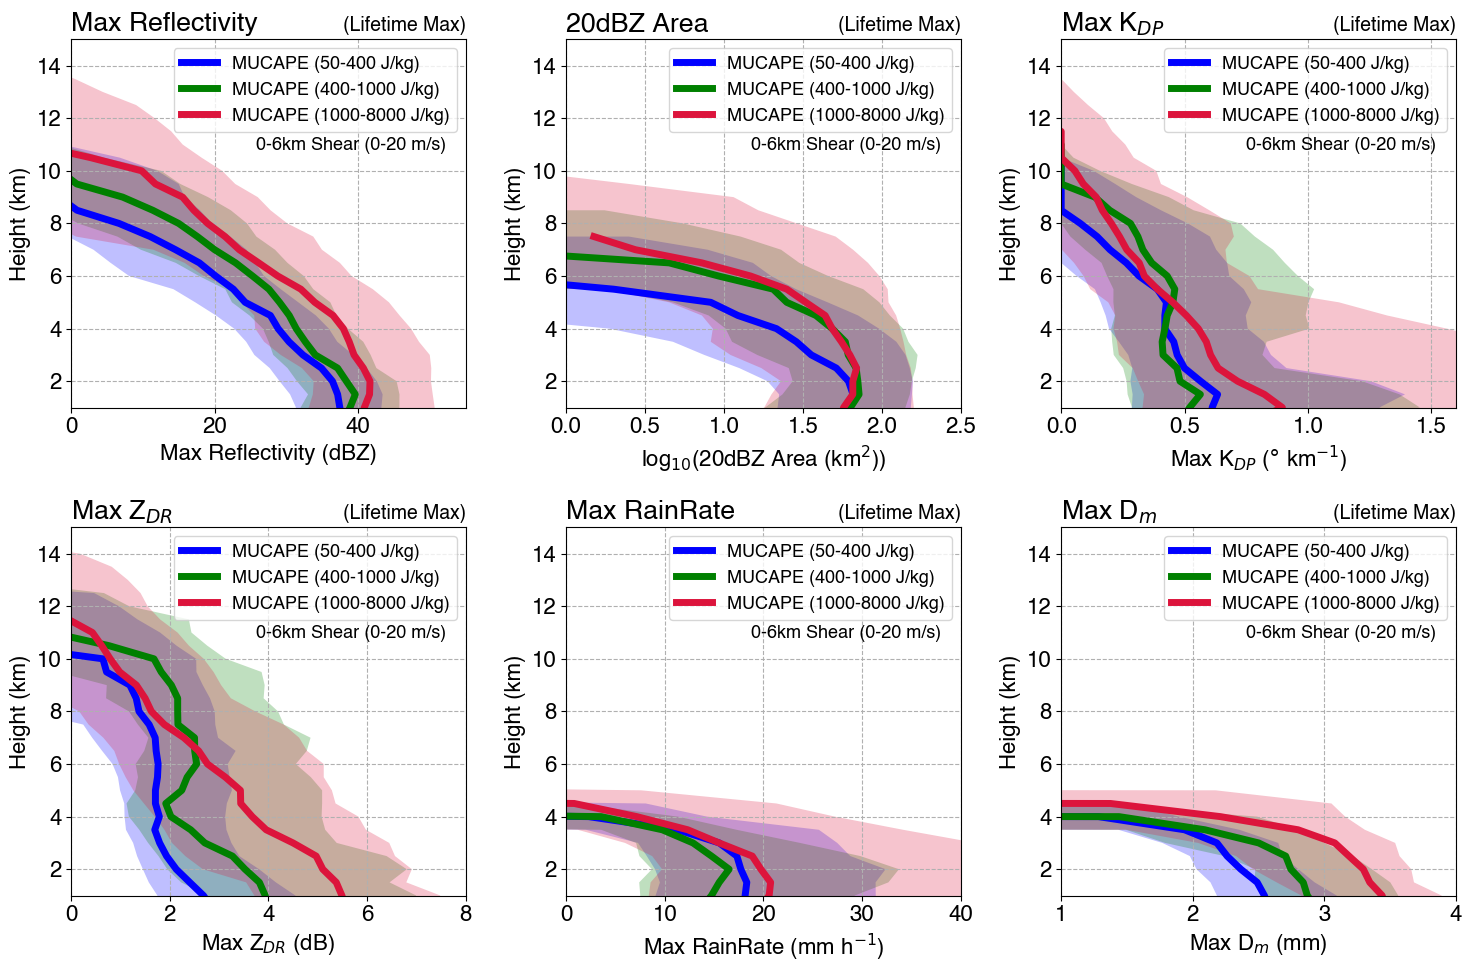

In [134]:
idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()
ybin = 0  # shear bin value [range: 0-2]
data1_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,0], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,0]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,0]],
             [max_zdr_maxprof_capeshear6mag_pts[idx50,:,ybin,0], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,ybin,0], max_Dm_maxprof_capeshear6mag_pts[idx50,:,ybin,0]]]
data2_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,1], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,1]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,1]],
             [max_zdr_maxprof_capeshear6mag_pts[idx50,:,ybin,1], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,ybin,1], max_Dm_maxprof_capeshear6mag_pts[idx50,:,ybin,1]]]
data3_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,ybin,2], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,ybin,2]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,ybin,2]],
             [max_zdr_maxprof_capeshear6mag_pts[idx50,:,ybin,2], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,ybin,2], max_Dm_maxprof_capeshear6mag_pts[idx50,:,ybin,2]]]
data1_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_dbz_maxprof_capeshear6mag_pts[idx75,:,ybin,0]),
              (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,0]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,ybin,0])),
              (max_kdp_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_kdp_maxprof_capeshear6mag_pts[idx75,:,ybin,0])], 
             [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_zdr_maxprof_capeshear6mag_pts[idx75,:,ybin,0]),
              (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,ybin,0]),
              (max_Dm_maxprof_capeshear6mag_pts[idx25,:,ybin,0], max_Dm_maxprof_capeshear6mag_pts[idx75,:,ybin,0])]]
data2_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_dbz_maxprof_capeshear6mag_pts[idx75,:,ybin,1]),
              (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,1]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,ybin,1])),
              (max_kdp_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_kdp_maxprof_capeshear6mag_pts[idx75,:,ybin,1])], 
             [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_zdr_maxprof_capeshear6mag_pts[idx75,:,ybin,1]),
              (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,ybin,1]),
              (max_Dm_maxprof_capeshear6mag_pts[idx25,:,ybin,1], max_Dm_maxprof_capeshear6mag_pts[idx75,:,ybin,1])]]
data3_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_dbz_maxprof_capeshear6mag_pts[idx75,:,ybin,2]),
              (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,ybin,2]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,ybin,2])),
              (max_kdp_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_kdp_maxprof_capeshear6mag_pts[idx75,:,ybin,2])], 
             [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_zdr_maxprof_capeshear6mag_pts[idx75,:,ybin,2]),
              (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,ybin,2]),
              (max_Dm_maxprof_capeshear6mag_pts[idx25,:,ybin,2], max_Dm_maxprof_capeshear6mag_pts[idx75,:,ybin,2])]]
xlims = [[(0,55), (0,2.5), (0,1.6)],
         [(0,8), (0,40), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
figname = f'{figdir}cell_max_profile_MUCPAE_shear0-6km_{shear6mag_range[ybin]:.0f}-{shear6mag_range[ybin+1]:.0f}ms.png'
titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
              ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
titles2 = '(Lifetime Max)'
legends = [f'MUCAPE ({cape_range[0]:.0f}-{cape_range[1]:.0f} J/kg)', 
           f'MUCAPE ({cape_range[1]:.0f}-{cape_range[2]:.0f} J/kg)', 
           f'MUCAPE ({cape_range[2]:.0f}-{cape_range[3]:.0f} J/kg)']
legend2 = f'0-6km Shear ({shear6mag_range[ybin]:.0f}-{shear6mag_range[ybin+1]:.0f} m/s)'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, legend2, figname)

<ipython-input-136-941ec0bd72d4>:8: RuntimeWarning: divide by zero encountered in log10
  data1_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,0,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,0,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,0,xbin]],
<ipython-input-136-941ec0bd72d4>:10: RuntimeWarning: divide by zero encountered in log10
  data2_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,1,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,1,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,1,xbin]],
<ipython-input-136-941ec0bd72d4>:12: RuntimeWarning: divide by zero encountered in log10
  data3_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,2,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,2,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,2,xbin]],
<ipython-input-136-941ec0bd72d4>:15: RuntimeWarning: divide by zero encountered in log10
  (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,0,xbin]), np.log10(dbz20_area_maxprof_c

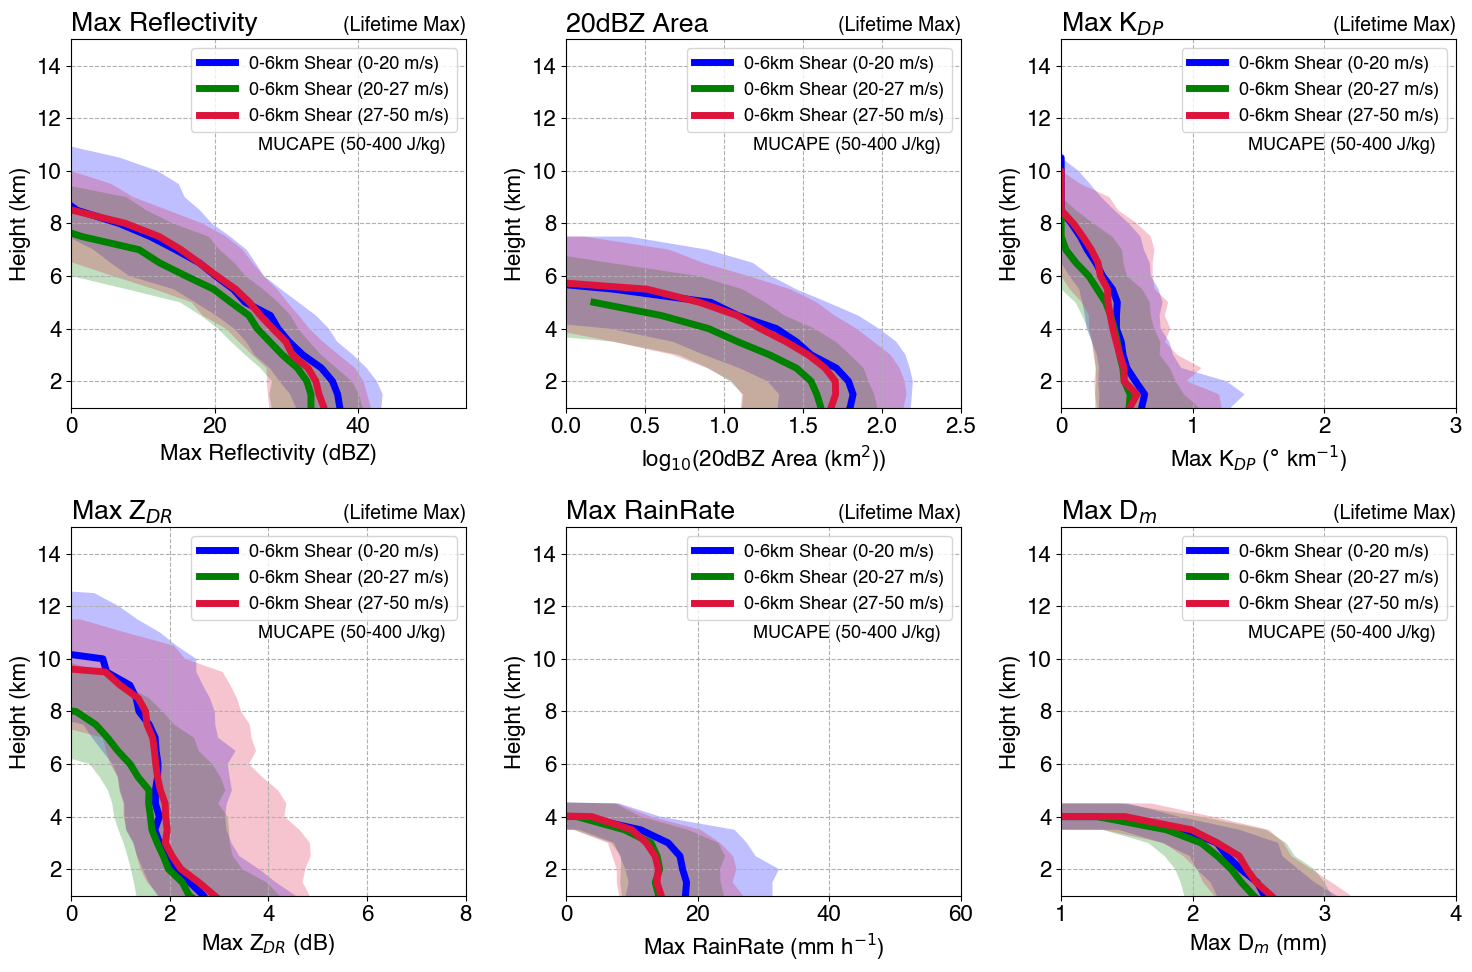

In [136]:
idx50 = np.where(np.array(quantiles_3d) == 0.5)[0].item()
idx25 = np.where(np.array(quantiles_3d) == 0.25)[0].item()
idx75 = np.where(np.array(quantiles_3d) == 0.75)[0].item()
xbin = 0  # MUCAPE bin value [range: 0-2]
# Replace 0 with a very small number to prevent Log10 returning invalid number
# dbz20_area_prof_tmp = np.copy(dbz20_area_maxprof_capeshear6mag_pts)
# dbz20_area_prof_tmp[np.where(dbz20_area_prof_tmp == 0)] = 1e-9
data1_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,0,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,0,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,0,xbin]],
             [max_zdr_maxprof_capeshear6mag_pts[idx50,:,0,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,0,xbin], max_Dm_maxprof_capeshear6mag_pts[idx50,:,0,xbin]]]
data2_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,1,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,1,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,1,xbin]],
             [max_zdr_maxprof_capeshear6mag_pts[idx50,:,1,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,1,xbin], max_Dm_maxprof_capeshear6mag_pts[idx50,:,1,xbin]]]
data3_avg = [[max_dbz_maxprof_capeshear6mag_pts[idx50,:,2,xbin], np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx50,:,2,xbin]), max_kdp_maxprof_capeshear6mag_pts[idx50,:,2,xbin]],
             [max_zdr_maxprof_capeshear6mag_pts[idx50,:,2,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx50,:,2,xbin], max_Dm_maxprof_capeshear6mag_pts[idx50,:,2,xbin]]]
data1_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_dbz_maxprof_capeshear6mag_pts[idx75,:,0,xbin]),
              (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,0,xbin]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,0,xbin])),
              (max_kdp_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_kdp_maxprof_capeshear6mag_pts[idx75,:,0,xbin])], 
             [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_zdr_maxprof_capeshear6mag_pts[idx75,:,0,xbin]),
              (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,0,xbin]),
              (max_Dm_maxprof_capeshear6mag_pts[idx25,:,0,xbin], max_Dm_maxprof_capeshear6mag_pts[idx75,:,0,xbin])]]
data2_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_dbz_maxprof_capeshear6mag_pts[idx75,:,1,xbin]),
              (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,1,xbin]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,1,xbin])),
              (max_kdp_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_kdp_maxprof_capeshear6mag_pts[idx75,:,1,xbin])], 
             [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_zdr_maxprof_capeshear6mag_pts[idx75,:,1,xbin]),
              (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,1,xbin]),
              (max_Dm_maxprof_capeshear6mag_pts[idx25,:,1,xbin], max_Dm_maxprof_capeshear6mag_pts[idx75,:,1,xbin])]]
data3_pts = [[(max_dbz_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_dbz_maxprof_capeshear6mag_pts[idx75,:,2,xbin]),
              (np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx25,:,2,xbin]), np.log10(dbz20_area_maxprof_capeshear6mag_pts[idx75,:,2,xbin])),
              (max_kdp_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_kdp_maxprof_capeshear6mag_pts[idx75,:,2,xbin])], 
             [(max_zdr_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_zdr_maxprof_capeshear6mag_pts[idx75,:,2,xbin]),
              (max_rainrate_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_rainrate_maxprof_capeshear6mag_pts[idx75,:,2,xbin]),
              (max_Dm_maxprof_capeshear6mag_pts[idx25,:,2,xbin], max_Dm_maxprof_capeshear6mag_pts[idx75,:,2,xbin])]]
xlims = [[(0,55), (0,2.5), (0,3)],
         [(0,8), (0,60), (1,4)]]
xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
           ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
figname = f'{figdir}cell_max_profile_shear0-6km_MUCAPE_{cape_range[xbin]:.0f}-{cape_range[xbin+1]:.0f}.png'
titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
              ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
titles2 = '(Lifetime Max)'
legends = [f'0-6km Shear ({shear6mag_range[0]:.0f}-{shear6mag_range[1]:.0f} m/s)', 
           f'0-6km Shear ({shear6mag_range[1]:.0f}-{shear6mag_range[2]:.0f} m/s)',
           f'0-6km Shear ({shear6mag_range[2]:.0f}-{shear6mag_range[3]:.0f} m/s)',]
legend2 = f'MUCAPE ({cape_range[xbin]:.0f}-{cape_range[xbin+1]:.0f} J/kg)'
fig = plot_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, legend2, figname)

In [95]:
# def quantiles_by1cond(in_var, cond_var, cond_range, loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles):
#     in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
#                                 (cond_var > cond_range[0]) & (cond_var <= cond_range[1]) & (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)

#     nsamples = in_var_cond.sizes['tracks']
    
#     # Calculate averages (NaN excluded)
# #     out_var_time0_avg = in_var_cond.isel(times=0).mean(dim='tracks')
# #     out_var_max_avg = in_var_cond.max(dim='times').mean(dim='tracks')
    
#     # Replace NaN with a large negative value to take into account decreasing sample with height
#     # NaN is excluded in quantile calculations which biases the sampling with increasing height
#     fillval = -99
#     in_var_cond = in_var_cond.where(~np.isnan(in_var_cond), other=fillval)
# #     in_var_cond_pts = in_var_cond.quantile(quantiles, dim='tracks', skipna=True)

# #     quantiles_prof = [0.25,0.5,0.75]
#     # Calculate initiation quantiles
#     out_var_time0_pts = in_var_cond.isel(times=0).quantile(quantiles, dim='tracks', skipna=True)
#     # Calculate max during lifetime quantiles
#     out_var_max_pts = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True)
    
#     return (nsamples, out_var_time0_pts, out_var_max_pts)

In [96]:
# quantiles = [0.5,0.75,0.9,0.95]
# cape_range1 = [50,400]
# cape_range2 = [400,900]
# cape_range3 = [900,4000]

# max_dbz1_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                         (cape > cape_range1[0]) & (cape <= cape_range1[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
# max_dbz2_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                         (cape > cape_range2[0]) & (cape <= cape_range2[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
# max_dbz3_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                         (cape > cape_range3[0]) & (cape <= cape_range3[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
# # Replace NaN with a large negative value to take into account decreasing sample with height
# # NaN is excluded in quantile calculations which biases the sampling with increasing height
# fillval = -99
# max_dbz1_cape = max_dbz1_cape.where(~np.isnan(max_dbz1_cape), other=fillval)
# max_dbz2_cape = max_dbz2_cape.where(~np.isnan(max_dbz2_cape), other=fillval)
# max_dbz3_cape = max_dbz3_cape.where(~np.isnan(max_dbz3_cape), other=fillval)
# max_dbz_dur1_cape_pts = max_dbz1_cape.quantile(quantiles, dim='tracks', skipna=True)
# max_dbz_dur2_cape_pts = max_dbz2_cape.quantile(quantiles, dim='tracks', skipna=True)
# max_dbz_dur3_cape_pts = max_dbz3_cape.quantile(quantiles, dim='tracks', skipna=True)

# quantiles_prof = [0.25,0.5,0.75]
# # Calculate initiation profile quantiles
# max_dbz1_prof0_cape_pts = max_dbz1_cape.isel(times=0).quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz2_prof0_cape_pts = max_dbz2_cape.isel(times=0).quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz3_prof0_cape_pts = max_dbz3_cape.isel(times=0).quantile(quantiles_prof, dim='tracks', skipna=True)
# # Calculate aggregate profile during the lifetime
# max_dbz1_maxprof_cape_pts = max_dbz1_cape.max(dim='times').quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz2_maxprof_cape_pts = max_dbz2_cape.max(dim='times').quantile(quantiles_prof, dim='tracks', skipna=True)
# max_dbz3_maxprof_cape_pts = max_dbz3_cape.max(dim='times').quantile(quantiles_prof, dim='tracks', skipna=True)

In [97]:
# quantiles_prof = [0.25,0.5,0.75]

# cape_range1 = [50,400]
# # cape_range2 = [400,900]
# # cape_range3 = [900,4000]
# cape_range2 = [400,1000]
# cape_range3 = [1000,6000]

# # Max reflectivity profile
# ntracks1_cape, max_dbz1_prof0_cape_pts, max_dbz1_maxprof_cape_pts = quantiles_by1cond(stats.max_reflectivity, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, max_dbz2_prof0_cape_pts, max_dbz2_maxprof_cape_pts = quantiles_by1cond(stats.max_reflectivity, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, max_dbz3_prof0_cape_pts, max_dbz3_maxprof_cape_pts = quantiles_by1cond(stats.max_reflectivity, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# print(f'Number of samples by MUCAPE: {ntracks1_cape}, {ntracks2_cape}, {ntracks3_cape}')
# # 20dBZ area
# ntracks1_cape, dbz20_area1_prof0_cape_pts, dbz20_area1_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, dbz20_area2_prof0_cape_pts, dbz20_area2_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, dbz20_area3_prof0_cape_pts, dbz20_area3_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # 30dBZ area
# ntracks1_cape, dbz30_area1_prof0_cape_pts, dbz30_area1_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, dbz30_area2_prof0_cape_pts, dbz30_area2_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, dbz30_area3_prof0_cape_pts, dbz30_area3_maxprof_cape_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max ZDR profile
# ntracks1_cape, max_zdr1_prof0_cape_pts, max_zdr1_maxprof_cape_pts = quantiles_by1cond(stats.max_zdr, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, max_zdr2_prof0_cape_pts, max_zdr2_maxprof_cape_pts = quantiles_by1cond(stats.max_zdr, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, max_zdr3_prof0_cape_pts, max_zdr3_maxprof_cape_pts = quantiles_by1cond(stats.max_zdr, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max KDP profile
# ntracks1_cape, max_kdp1_prof0_cape_pts, max_kdp1_maxprof_cape_pts = quantiles_by1cond(stats.max_kdp, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, max_kdp2_prof0_cape_pts, max_kdp2_maxprof_cape_pts = quantiles_by1cond(stats.max_kdp, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, max_kdp3_prof0_cape_pts, max_kdp3_maxprof_cape_pts = quantiles_by1cond(stats.max_kdp, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max rainrate profile
# ntracks1_cape, max_rainrate1_prof0_cape_pts, max_rainrate1_maxprof_cape_pts = quantiles_by1cond(stats.max_rainrate, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, max_rainrate2_prof0_cape_pts, max_rainrate2_maxprof_cape_pts = quantiles_by1cond(stats.max_rainrate, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, max_rainrate3_prof0_cape_pts, max_rainrate3_maxprof_cape_pts = quantiles_by1cond(stats.max_rainrate, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max Dm profile
# ntracks1_cape, max_Dm1_prof0_cape_pts, max_Dm1_maxprof_cape_pts = quantiles_by1cond(stats.max_Dm, cape, cape_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_cape, max_Dm2_prof0_cape_pts, max_Dm2_maxprof_cape_pts = quantiles_by1cond(stats.max_Dm, cape, cape_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_cape, max_Dm3_prof0_cape_pts, max_Dm3_maxprof_cape_pts = quantiles_by1cond(stats.max_Dm, cape, cape_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)

In [98]:
# q850p_range1 = [2,8]
# q850p_range2 = [8,12]
# q850p_range3 = [12,20]

# # Max reflectivity profile
# ntracks1_q850p, max_dbz1_prof0_q850p_pts, max_dbz1_maxprof_q850p_pts = quantiles_by1cond(stats.max_reflectivity, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, max_dbz2_prof0_q850p_pts, max_dbz2_maxprof_q850p_pts = quantiles_by1cond(stats.max_reflectivity, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, max_dbz3_prof0_q850p_pts, max_dbz3_maxprof_q850p_pts = quantiles_by1cond(stats.max_reflectivity, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# print(f'Number of samples by 850hPa q: {ntracks1_q850p}, {ntracks2_q850p}, {ntracks3_q850p}')

# # 20dBZ area
# ntracks1_q850p, dbz20_area1_prof0_q850p_pts, dbz20_area1_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, dbz20_area2_prof0_q850p_pts, dbz20_area2_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, dbz20_area3_prof0_q850p_pts, dbz20_area3_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # 30dBZ area
# ntracks1_q850p, dbz30_area1_prof0_q850p_pts, dbz30_area1_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, dbz30_area2_prof0_q850p_pts, dbz30_area2_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, dbz30_area3_prof0_q850p_pts, dbz30_area3_maxprof_q850p_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max ZDR profile
# ntracks1_q850p, max_zdr1_prof0_q850p_pts, max_zdr1_maxprof_q850p_pts = quantiles_by1cond(stats.max_zdr, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, max_zdr2_prof0_q850p_pts, max_zdr2_maxprof_q850p_pts = quantiles_by1cond(stats.max_zdr, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, max_zdr3_prof0_q850p_pts, max_zdr3_maxprof_q850p_pts = quantiles_by1cond(stats.max_zdr, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max KDP profile
# ntracks1_q850p, max_kdp1_prof0_q850p_pts, max_kdp1_maxprof_q850p_pts = quantiles_by1cond(stats.max_kdp, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, max_kdp2_prof0_q850p_pts, max_kdp2_maxprof_q850p_pts = quantiles_by1cond(stats.max_kdp, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, max_kdp3_prof0_q850p_pts, max_kdp3_maxprof_q850p_pts = quantiles_by1cond(stats.max_kdp, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max rainrate profile
# ntracks1_q850p, max_rainrate1_prof0_q850p_pts, max_rainrate1_maxprof_q850p_pts = quantiles_by1cond(stats.max_rainrate, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, max_rainrate2_prof0_q850p_pts, max_rainrate2_maxprof_q850p_pts = quantiles_by1cond(stats.max_rainrate, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, max_rainrate3_prof0_q850p_pts, max_rainrate3_maxprof_q850p_pts = quantiles_by1cond(stats.max_rainrate, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max Dm profile
# ntracks1_q850p, max_Dm1_prof0_q850p_pts, max_Dm1_maxprof_q850p_pts = quantiles_by1cond(stats.max_Dm, q850p, q850p_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_q850p, max_Dm2_prof0_q850p_pts, max_Dm2_maxprof_q850p_pts = quantiles_by1cond(stats.max_Dm, q850p, q850p_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_q850p, max_Dm3_prof0_q850p_pts, max_Dm3_maxprof_q850p_pts = quantiles_by1cond(stats.max_Dm, q850p, q850p_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)

In [99]:
# shear6mag_range1 = [0,20]
# shear6mag_range2 = [20,28]
# shear6mag_range3 = [28,50]

# # shear6mag = stats.shear6mag.sel(reltime=0)

# # Max reflectivity profile
# ntracks1_shear6mag, max_dbz1_prof0_shear6mag_pts, max_dbz1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_reflectivity, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, max_dbz2_prof0_shear6mag_pts, max_dbz2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_reflectivity, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, max_dbz3_prof0_shear6mag_pts, max_dbz3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_reflectivity, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# print(f'Number of samples by 850hPa q: {ntracks1_shear6mag}, {ntracks2_shear6mag}, {ntracks3_shear6mag}')

# # 20dBZ area
# ntracks1_shear6mag, dbz20_area1_prof0_shear6mag_pts, dbz20_area1_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, dbz20_area2_prof0_shear6mag_pts, dbz20_area2_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, dbz20_area3_prof0_shear6mag_pts, dbz20_area3_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # 30dBZ area
# ntracks1_shear6mag, dbz30_area1_prof0_shear6mag_pts, dbz30_area1_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, dbz30_area2_prof0_shear6mag_pts, dbz30_area2_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, dbz30_area3_prof0_shear6mag_pts, dbz30_area3_maxprof_shear6mag_pts = quantiles_by1cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max ZDR profile
# ntracks1_shear6mag, max_zdr1_prof0_shear6mag_pts, max_zdr1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_zdr, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, max_zdr2_prof0_shear6mag_pts, max_zdr2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_zdr, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, max_zdr3_prof0_shear6mag_pts, max_zdr3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_zdr, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max KDP profile
# ntracks1_shear6mag, max_kdp1_prof0_shear6mag_pts, max_kdp1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_kdp, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, max_kdp2_prof0_shear6mag_pts, max_kdp2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_kdp, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, max_kdp3_prof0_shear6mag_pts, max_kdp3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_kdp, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max rainrate profile
# ntracks1_shear6mag, max_rainrate1_prof0_shear6mag_pts, max_rainrate1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_rainrate, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, max_rainrate2_prof0_shear6mag_pts, max_rainrate2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_rainrate, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, max_rainrate3_prof0_shear6mag_pts, max_rainrate3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_rainrate, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# # Max Dm profile
# ntracks1_shear6mag, max_Dm1_prof0_shear6mag_pts, max_Dm1_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_Dm, shear6mag, shear6mag_range1, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks2_shear6mag, max_Dm2_prof0_shear6mag_pts, max_Dm2_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_Dm, shear6mag, shear6mag_range2, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)
# ntracks3_shear6mag, max_Dm3_prof0_shear6mag_pts, max_Dm3_maxprof_shear6mag_pts = quantiles_by1cond(stats.max_Dm, shear6mag, shear6mag_range3, start_lon, lon_eSDC, 
#                                                                         end_merge_tracknumber, start_split_tracknumber, quantiles_prof)

In [100]:
# dbz20_area1_prof0_cape_pts.sel(quantile=0.5).plot()
# dbz30_area2_prof0_cape_pts.sel(quantile=0.5).plot()
# dbz30_area3_prof0_cape_pts.sel(quantile=0.5).plot()

In [101]:
# def plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname):
#     mpl.rcParams['font.size'] = 16
#     mpl.rcParams['font.family'] = 'Helvetica'
#     mpl.rcParams['figure.facecolor'] = 'white'
#     fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)

#     ylims = [1, 15]
#     colors = {'low':'blue', 'medium':'green', 'high':'crimson'}
    
#     for row in range(2):
#         for col in range(3):
#             ax = axes[row, col]
#             ax.plot(data1_avg[row][col], height, color=colors['low'], lw=5, label=legends[0])
#             ax.plot(data2_avg[row][col], height, color=colors['medium'], lw=5, label=legends[1])
#             ax.plot(data3_avg[row][col], height, color=colors['high'], lw=5, label=legends[2])
#             # Replace left fill values with -99 if right fill value is not inf
#             fill1 = [data1_pts[row][col][0], data1_pts[row][col][1]]
#             fill2 = [data2_pts[row][col][0], data2_pts[row][col][1]]
#             fill3 = [data3_pts[row][col][0], data3_pts[row][col][1]]
#             idx1 = np.where((np.isinf(fill1[0]) & ~np.isinf(fill1[1])))
#             idx2 = np.where((np.isinf(fill2[0]) & ~np.isinf(fill2[1])))
#             idx3 = np.where((np.isinf(fill3[0]) & ~np.isinf(fill3[1])))
#             fill1[0][idx1] = -99
#             fill2[0][idx2] = -99
#             fill3[0][idx3] = -99
#             ax.fill_betweenx(height, fill1[0], fill1[1], color=colors['low'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, fill2[0], fill2[1], color=colors['medium'], edgecolor=None, alpha=0.25)
#             ax.fill_betweenx(height, fill3[0], fill3[1], color=colors['high'], edgecolor=None, alpha=0.25)
# #             ax.fill_betweenx(height, data1_pts[row][col][0], data1_pts[row][col][1], color=colors['low'], edgecolor=None, alpha=0.25)
# #             ax.fill_betweenx(height, data2_pts[row][col][0], data2_pts[row][col][1], color=colors['medium'], edgecolor=None, alpha=0.25)
# #             ax.fill_betweenx(height, data3_pts[row][col][0], data3_pts[row][col][1], color=colors['high'], edgecolor=None, alpha=0.25)
#             ax.grid(ls='--')
#             ax.set_xlim(xlims[row][col][0], xlims[row][col][1])
#             ax.set_ylim(ylims[0], ylims[1])
#             ax.set_xlabel(xlabels[row][col])
#             ax.set_ylabel('Height (km)')
#             ax.set_title(titles1[row][col], loc='left')
#             ax.set_title(titles2, loc='right', fontsize=14)
#             ax.legend(loc='upper right', fontsize=12)
    
#     fig.tight_layout()
#     fig.savefig(figname, bbox_inches='tight', dpi=300)
#     return fig

In [102]:
# data1_avg = [[max_dbz1_prof0_cape_pts.sel(quantile=0.5), np.log10(dbz20_area1_prof0_cape_pts).sel(quantile=0.5), max_kdp1_prof0_cape_pts.sel(quantile=0.5)],
#              [max_zdr1_prof0_cape_pts.sel(quantile=0.5), max_rainrate1_prof0_cape_pts.sel(quantile=0.5), max_Dm1_prof0_cape_pts.sel(quantile=0.5)]]
# data2_avg = [[max_dbz2_prof0_cape_pts.sel(quantile=0.5), np.log10(dbz20_area2_prof0_cape_pts).sel(quantile=0.5), max_kdp2_prof0_cape_pts.sel(quantile=0.5)],
#              [max_zdr2_prof0_cape_pts.sel(quantile=0.5), max_rainrate2_prof0_cape_pts.sel(quantile=0.5), max_Dm2_prof0_cape_pts.sel(quantile=0.5)]]
# data3_avg = [[max_dbz3_prof0_cape_pts.sel(quantile=0.5), np.log10(dbz20_area3_prof0_cape_pts).sel(quantile=0.5), max_kdp3_prof0_cape_pts.sel(quantile=0.5)],
#              [max_zdr3_prof0_cape_pts.sel(quantile=0.5), max_rainrate3_prof0_cape_pts.sel(quantile=0.5), max_Dm3_prof0_cape_pts.sel(quantile=0.5)]]
# data1_pts = [[(max_dbz1_prof0_cape_pts.sel(quantile=0.25), max_dbz1_prof0_cape_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area1_prof0_cape_pts).sel(quantile=0.25), np.log10(dbz20_area1_prof0_cape_pts).sel(quantile=0.75)), 
#               (max_kdp1_prof0_cape_pts.sel(quantile=0.25), max_kdp1_prof0_cape_pts.sel(quantile=0.75))],
#              [(max_zdr1_prof0_cape_pts.sel(quantile=0.25), max_zdr1_prof0_cape_pts.sel(quantile=0.75)),
#               (max_rainrate1_prof0_cape_pts.sel(quantile=0.25), max_rainrate1_prof0_cape_pts.sel(quantile=0.75)),
#               (max_Dm1_prof0_cape_pts.sel(quantile=0.25), max_Dm1_prof0_cape_pts.sel(quantile=0.75))]]
# data2_pts = [[(max_dbz2_prof0_cape_pts.sel(quantile=0.25), max_dbz2_prof0_cape_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area2_prof0_cape_pts).sel(quantile=0.25), np.log10(dbz20_area2_prof0_cape_pts).sel(quantile=0.75)), 
#               (max_kdp2_prof0_cape_pts.sel(quantile=0.25), max_kdp2_prof0_cape_pts.sel(quantile=0.75))],
#              [(max_zdr2_prof0_cape_pts.sel(quantile=0.25), max_zdr2_prof0_cape_pts.sel(quantile=0.75)),
#               (max_rainrate2_prof0_cape_pts.sel(quantile=0.25), max_rainrate2_prof0_cape_pts.sel(quantile=0.75)),
#               (max_Dm2_prof0_cape_pts.sel(quantile=0.25), max_Dm2_prof0_cape_pts.sel(quantile=0.75))]]
# data3_pts = [[(max_dbz3_prof0_cape_pts.sel(quantile=0.25), max_dbz3_prof0_cape_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area3_prof0_cape_pts).sel(quantile=0.25), np.log10(dbz20_area3_prof0_cape_pts).sel(quantile=0.75)), 
#               (max_kdp3_prof0_cape_pts.sel(quantile=0.25), max_kdp3_prof0_cape_pts.sel(quantile=0.75))],
#              [(max_zdr3_prof0_cape_pts.sel(quantile=0.25), max_zdr3_prof0_cape_pts.sel(quantile=0.75)),
#               (max_rainrate3_prof0_cape_pts.sel(quantile=0.25), max_rainrate3_prof0_cape_pts.sel(quantile=0.75)),
#               (max_Dm3_prof0_cape_pts.sel(quantile=0.25), max_Dm3_prof0_cape_pts.sel(quantile=0.75))]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_initiation_profile_MUCPAE.png'
# titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Initiation)'
# legends = [f'MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
#            f'MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
#            f'MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
# fig = plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [103]:
# data1_avg = [[max_dbz1_maxprof_cape_pts.sel(quantile=0.5), np.log10(dbz20_area1_maxprof_cape_pts).sel(quantile=0.5), max_kdp1_maxprof_cape_pts.sel(quantile=0.5)],
#              [max_zdr1_maxprof_cape_pts.sel(quantile=0.5), max_rainrate1_maxprof_cape_pts.sel(quantile=0.5), max_Dm1_maxprof_cape_pts.sel(quantile=0.5)]]
# data2_avg = [[max_dbz2_maxprof_cape_pts.sel(quantile=0.5), np.log10(dbz20_area2_maxprof_cape_pts).sel(quantile=0.5), max_kdp2_maxprof_cape_pts.sel(quantile=0.5)],
#              [max_zdr2_maxprof_cape_pts.sel(quantile=0.5), max_rainrate2_maxprof_cape_pts.sel(quantile=0.5), max_Dm2_maxprof_cape_pts.sel(quantile=0.5)]]
# data3_avg = [[max_dbz3_maxprof_cape_pts.sel(quantile=0.5), np.log10(dbz20_area3_maxprof_cape_pts).sel(quantile=0.5), max_kdp3_maxprof_cape_pts.sel(quantile=0.5)],
#              [max_zdr3_maxprof_cape_pts.sel(quantile=0.5), max_rainrate3_maxprof_cape_pts.sel(quantile=0.5), max_Dm3_maxprof_cape_pts.sel(quantile=0.5)]]
# data1_pts = [[(max_dbz1_maxprof_cape_pts.sel(quantile=0.25), max_dbz1_maxprof_cape_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area1_maxprof_cape_pts).sel(quantile=0.25), np.log10(dbz20_area1_maxprof_cape_pts).sel(quantile=0.75)), 
#               (max_kdp1_maxprof_cape_pts.sel(quantile=0.25), max_kdp1_maxprof_cape_pts.sel(quantile=0.75))],
#              [(max_zdr1_maxprof_cape_pts.sel(quantile=0.25), max_zdr1_maxprof_cape_pts.sel(quantile=0.75)),
#               (max_rainrate1_maxprof_cape_pts.sel(quantile=0.25), max_rainrate1_maxprof_cape_pts.sel(quantile=0.75)),
#               (max_Dm1_maxprof_cape_pts.sel(quantile=0.25), max_Dm1_maxprof_cape_pts.sel(quantile=0.75))]]
# data2_pts = [[(max_dbz2_maxprof_cape_pts.sel(quantile=0.25), max_dbz2_maxprof_cape_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area2_maxprof_cape_pts).sel(quantile=0.25), np.log10(dbz20_area2_maxprof_cape_pts).sel(quantile=0.75)), 
#               (max_kdp2_maxprof_cape_pts.sel(quantile=0.25), max_kdp2_maxprof_cape_pts.sel(quantile=0.75))],
#              [(max_zdr2_maxprof_cape_pts.sel(quantile=0.25), max_zdr2_maxprof_cape_pts.sel(quantile=0.75)),
#               (max_rainrate2_maxprof_cape_pts.sel(quantile=0.25), max_rainrate2_maxprof_cape_pts.sel(quantile=0.75)),
#               (max_Dm2_maxprof_cape_pts.sel(quantile=0.25), max_Dm2_maxprof_cape_pts.sel(quantile=0.75))]]
# data3_pts = [[(max_dbz3_maxprof_cape_pts.sel(quantile=0.25), max_dbz3_maxprof_cape_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area3_maxprof_cape_pts).sel(quantile=0.25), np.log10(dbz20_area3_maxprof_cape_pts).sel(quantile=0.75)), 
#               (max_kdp3_maxprof_cape_pts.sel(quantile=0.25), max_kdp3_maxprof_cape_pts.sel(quantile=0.75))],
#              [(max_zdr3_maxprof_cape_pts.sel(quantile=0.25), max_zdr3_maxprof_cape_pts.sel(quantile=0.75)),
#               (max_rainrate3_maxprof_cape_pts.sel(quantile=0.25), max_rainrate3_maxprof_cape_pts.sel(quantile=0.75)),
#               (max_Dm3_maxprof_cape_pts.sel(quantile=0.25), max_Dm3_maxprof_cape_pts.sel(quantile=0.75))]]
# xlims = [[(0,55), (0,2.5), (0,3)],
#          [(0,8), (0,80), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_max_profile_MUCPAE.png'
# titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Lifetime Max)'
# legends = [f'MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
#            f'MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
#            f'MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
# fig = plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [104]:
# data1_avg = [[max_dbz1_prof0_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area1_prof0_q850p_pts).sel(quantile=0.5), max_kdp1_prof0_q850p_pts.sel(quantile=0.5)],
#              [max_zdr1_prof0_q850p_pts.sel(quantile=0.5), max_rainrate1_prof0_q850p_pts.sel(quantile=0.5), max_Dm1_prof0_q850p_pts.sel(quantile=0.5)]]
# data2_avg = [[max_dbz2_prof0_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area2_prof0_q850p_pts).sel(quantile=0.5), max_kdp2_prof0_q850p_pts.sel(quantile=0.5)],
#              [max_zdr2_prof0_q850p_pts.sel(quantile=0.5), max_rainrate2_prof0_q850p_pts.sel(quantile=0.5), max_Dm2_prof0_q850p_pts.sel(quantile=0.5)]]
# data3_avg = [[max_dbz3_prof0_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area3_prof0_q850p_pts).sel(quantile=0.5), max_kdp3_prof0_q850p_pts.sel(quantile=0.5)],
#              [max_zdr3_prof0_q850p_pts.sel(quantile=0.5), max_rainrate3_prof0_q850p_pts.sel(quantile=0.5), max_Dm3_prof0_q850p_pts.sel(quantile=0.5)]]
# data1_pts = [[(max_dbz1_prof0_q850p_pts.sel(quantile=0.25), max_dbz1_prof0_q850p_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area1_prof0_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area1_prof0_q850p_pts).sel(quantile=0.75)), 
#               (max_kdp1_prof0_q850p_pts.sel(quantile=0.25), max_kdp1_prof0_q850p_pts.sel(quantile=0.75))],
#              [(max_zdr1_prof0_q850p_pts.sel(quantile=0.25), max_zdr1_prof0_q850p_pts.sel(quantile=0.75)),
#               (max_rainrate1_prof0_q850p_pts.sel(quantile=0.25), max_rainrate1_prof0_q850p_pts.sel(quantile=0.75)),
#               (max_Dm1_prof0_q850p_pts.sel(quantile=0.25), max_Dm1_prof0_q850p_pts.sel(quantile=0.75))]]
# data2_pts = [[(max_dbz2_prof0_q850p_pts.sel(quantile=0.25), max_dbz2_prof0_q850p_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area2_prof0_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area2_prof0_q850p_pts).sel(quantile=0.75)), 
#               (max_kdp2_prof0_q850p_pts.sel(quantile=0.25), max_kdp2_prof0_q850p_pts.sel(quantile=0.75))],
#              [(max_zdr2_prof0_q850p_pts.sel(quantile=0.25), max_zdr2_prof0_q850p_pts.sel(quantile=0.75)),
#               (max_rainrate2_prof0_q850p_pts.sel(quantile=0.25), max_rainrate2_prof0_q850p_pts.sel(quantile=0.75)),
#               (max_Dm2_prof0_q850p_pts.sel(quantile=0.25), max_Dm2_prof0_q850p_pts.sel(quantile=0.75))]]
# data3_pts = [[(max_dbz3_prof0_q850p_pts.sel(quantile=0.25), max_dbz3_prof0_q850p_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area3_prof0_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area3_prof0_q850p_pts).sel(quantile=0.75)), 
#               (max_kdp3_prof0_q850p_pts.sel(quantile=0.25), max_kdp3_prof0_q850p_pts.sel(quantile=0.75))],
#              [(max_zdr3_prof0_q850p_pts.sel(quantile=0.25), max_zdr3_prof0_q850p_pts.sel(quantile=0.75)),
#               (max_rainrate3_prof0_q850p_pts.sel(quantile=0.25), max_rainrate3_prof0_q850p_pts.sel(quantile=0.75)),
#               (max_Dm3_prof0_q850p_pts.sel(quantile=0.25), max_Dm3_prof0_q850p_pts.sel(quantile=0.75))]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_initiation_profile_q850hpa.png'
# titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Initiation)'
# legends = [f'850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} g/kg)', 
#            f'850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} g/kg)', 
#            f'850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} g/kg)']
# fig = plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [105]:
# data1_avg = [[max_dbz1_maxprof_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area1_maxprof_q850p_pts).sel(quantile=0.5), max_kdp1_maxprof_q850p_pts.sel(quantile=0.5)],
#              [max_zdr1_maxprof_q850p_pts.sel(quantile=0.5), max_rainrate1_maxprof_q850p_pts.sel(quantile=0.5), max_Dm1_maxprof_q850p_pts.sel(quantile=0.5)]]
# data2_avg = [[max_dbz2_maxprof_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area2_maxprof_q850p_pts).sel(quantile=0.5), max_kdp2_maxprof_q850p_pts.sel(quantile=0.5)],
#              [max_zdr2_maxprof_q850p_pts.sel(quantile=0.5), max_rainrate2_maxprof_q850p_pts.sel(quantile=0.5), max_Dm2_maxprof_q850p_pts.sel(quantile=0.5)]]
# data3_avg = [[max_dbz3_maxprof_q850p_pts.sel(quantile=0.5), np.log10(dbz20_area3_maxprof_q850p_pts).sel(quantile=0.5), max_kdp3_maxprof_q850p_pts.sel(quantile=0.5)],
#              [max_zdr3_maxprof_q850p_pts.sel(quantile=0.5), max_rainrate3_maxprof_q850p_pts.sel(quantile=0.5), max_Dm3_maxprof_q850p_pts.sel(quantile=0.5)]]
# data1_pts = [[(max_dbz1_maxprof_q850p_pts.sel(quantile=0.25), max_dbz1_maxprof_q850p_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area1_maxprof_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area1_maxprof_q850p_pts).sel(quantile=0.75)), 
#               (max_kdp1_maxprof_q850p_pts.sel(quantile=0.25), max_kdp1_maxprof_q850p_pts.sel(quantile=0.75))],
#              [(max_zdr1_maxprof_q850p_pts.sel(quantile=0.25), max_zdr1_maxprof_q850p_pts.sel(quantile=0.75)),
#               (max_rainrate1_maxprof_q850p_pts.sel(quantile=0.25), max_rainrate1_maxprof_q850p_pts.sel(quantile=0.75)),
#               (max_Dm1_maxprof_q850p_pts.sel(quantile=0.25), max_Dm1_maxprof_q850p_pts.sel(quantile=0.75))]]
# data2_pts = [[(max_dbz2_maxprof_q850p_pts.sel(quantile=0.25), max_dbz2_maxprof_q850p_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area2_maxprof_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area2_maxprof_q850p_pts).sel(quantile=0.75)), 
#               (max_kdp2_maxprof_q850p_pts.sel(quantile=0.25), max_kdp2_maxprof_q850p_pts.sel(quantile=0.75))],
#              [(max_zdr2_maxprof_q850p_pts.sel(quantile=0.25), max_zdr2_maxprof_q850p_pts.sel(quantile=0.75)),
#               (max_rainrate2_maxprof_q850p_pts.sel(quantile=0.25), max_rainrate2_maxprof_q850p_pts.sel(quantile=0.75)),
#               (max_Dm2_maxprof_q850p_pts.sel(quantile=0.25), max_Dm2_maxprof_q850p_pts.sel(quantile=0.75))]]
# data3_pts = [[(max_dbz3_maxprof_q850p_pts.sel(quantile=0.25), max_dbz3_maxprof_q850p_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area3_maxprof_q850p_pts).sel(quantile=0.25), np.log10(dbz20_area3_maxprof_q850p_pts).sel(quantile=0.75)), 
#               (max_kdp3_maxprof_q850p_pts.sel(quantile=0.25), max_kdp3_maxprof_q850p_pts.sel(quantile=0.75))],
#              [(max_zdr3_maxprof_q850p_pts.sel(quantile=0.25), max_zdr3_maxprof_q850p_pts.sel(quantile=0.75)),
#               (max_rainrate3_maxprof_q850p_pts.sel(quantile=0.25), max_rainrate3_maxprof_q850p_pts.sel(quantile=0.75)),
#               (max_Dm3_maxprof_q850p_pts.sel(quantile=0.25), max_Dm3_maxprof_q850p_pts.sel(quantile=0.75))]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_max_profile_q850hpa.png'
# titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Lifetime Max)'
# legends = [f'850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} g/kg)', 
#            f'850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} g/kg)', 
#            f'850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} g/kg)']
# fig = plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [106]:
# data1_avg = [[max_dbz1_prof0_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area1_prof0_shear6mag_pts).sel(quantile=0.5), max_kdp1_prof0_shear6mag_pts.sel(quantile=0.5)],
#              [max_zdr1_prof0_shear6mag_pts.sel(quantile=0.5), max_rainrate1_prof0_shear6mag_pts.sel(quantile=0.5), max_Dm1_prof0_shear6mag_pts.sel(quantile=0.5)]]
# data2_avg = [[max_dbz2_prof0_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area2_prof0_shear6mag_pts).sel(quantile=0.5), max_kdp2_prof0_shear6mag_pts.sel(quantile=0.5)],
#              [max_zdr2_prof0_shear6mag_pts.sel(quantile=0.5), max_rainrate2_prof0_shear6mag_pts.sel(quantile=0.5), max_Dm2_prof0_shear6mag_pts.sel(quantile=0.5)]]
# data3_avg = [[max_dbz3_prof0_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area3_prof0_shear6mag_pts).sel(quantile=0.5), max_kdp3_prof0_shear6mag_pts.sel(quantile=0.5)],
#              [max_zdr3_prof0_shear6mag_pts.sel(quantile=0.5), max_rainrate3_prof0_shear6mag_pts.sel(quantile=0.5), max_Dm3_prof0_shear6mag_pts.sel(quantile=0.5)]]
# data1_pts = [[(max_dbz1_prof0_shear6mag_pts.sel(quantile=0.25), max_dbz1_prof0_shear6mag_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area1_prof0_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area1_prof0_shear6mag_pts).sel(quantile=0.75)), 
#               (max_kdp1_prof0_shear6mag_pts.sel(quantile=0.25), max_kdp1_prof0_shear6mag_pts.sel(quantile=0.75))],
#              [(max_zdr1_prof0_shear6mag_pts.sel(quantile=0.25), max_zdr1_prof0_shear6mag_pts.sel(quantile=0.75)),
#               (max_rainrate1_prof0_shear6mag_pts.sel(quantile=0.25), max_rainrate1_prof0_shear6mag_pts.sel(quantile=0.75)),
#               (max_Dm1_prof0_shear6mag_pts.sel(quantile=0.25), max_Dm1_prof0_shear6mag_pts.sel(quantile=0.75))]]
# data2_pts = [[(max_dbz2_prof0_shear6mag_pts.sel(quantile=0.25), max_dbz2_prof0_shear6mag_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area2_prof0_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area2_prof0_shear6mag_pts).sel(quantile=0.75)), 
#               (max_kdp2_prof0_shear6mag_pts.sel(quantile=0.25), max_kdp2_prof0_shear6mag_pts.sel(quantile=0.75))],
#              [(max_zdr2_prof0_shear6mag_pts.sel(quantile=0.25), max_zdr2_prof0_shear6mag_pts.sel(quantile=0.75)),
#               (max_rainrate2_prof0_shear6mag_pts.sel(quantile=0.25), max_rainrate2_prof0_shear6mag_pts.sel(quantile=0.75)),
#               (max_Dm2_prof0_shear6mag_pts.sel(quantile=0.25), max_Dm2_prof0_shear6mag_pts.sel(quantile=0.75))]]
# data3_pts = [[(max_dbz3_prof0_shear6mag_pts.sel(quantile=0.25), max_dbz3_prof0_shear6mag_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area3_prof0_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area3_prof0_shear6mag_pts).sel(quantile=0.75)), 
#               (max_kdp3_prof0_shear6mag_pts.sel(quantile=0.25), max_kdp3_prof0_shear6mag_pts.sel(quantile=0.75))],
#              [(max_zdr3_prof0_shear6mag_pts.sel(quantile=0.25), max_zdr3_prof0_shear6mag_pts.sel(quantile=0.75)),
#               (max_rainrate3_prof0_shear6mag_pts.sel(quantile=0.25), max_rainrate3_prof0_shear6mag_pts.sel(quantile=0.75)),
#               (max_Dm3_prof0_shear6mag_pts.sel(quantile=0.25), max_Dm3_prof0_shear6mag_pts.sel(quantile=0.75))]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_initiation_profile_shear0-6km.png'
# titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Initiation)'
# legends = [f'0-6km shear ({shear6mag_range1[0]}-{shear6mag_range1[1]} '+'m s$^{-1}$)', 
#            f'0-6km shear ({shear6mag_range2[0]}-{shear6mag_range2[1]} '+'m s$^{-1}$)', 
#            f'0-6km shear ({shear6mag_range3[0]}-{shear6mag_range3[1]} '+'m s$^{-1}$)']
# fig = plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [107]:
# data1_avg = [[max_dbz1_maxprof_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area1_maxprof_shear6mag_pts).sel(quantile=0.5), max_kdp1_maxprof_shear6mag_pts.sel(quantile=0.5)],
#              [max_zdr1_maxprof_shear6mag_pts.sel(quantile=0.5), max_rainrate1_maxprof_shear6mag_pts.sel(quantile=0.5), max_Dm1_maxprof_shear6mag_pts.sel(quantile=0.5)]]
# data2_avg = [[max_dbz2_maxprof_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area2_maxprof_shear6mag_pts).sel(quantile=0.5), max_kdp2_maxprof_shear6mag_pts.sel(quantile=0.5)],
#              [max_zdr2_maxprof_shear6mag_pts.sel(quantile=0.5), max_rainrate2_maxprof_shear6mag_pts.sel(quantile=0.5), max_Dm2_maxprof_shear6mag_pts.sel(quantile=0.5)]]
# data3_avg = [[max_dbz3_maxprof_shear6mag_pts.sel(quantile=0.5), np.log10(dbz20_area3_maxprof_shear6mag_pts).sel(quantile=0.5), max_kdp3_maxprof_shear6mag_pts.sel(quantile=0.5)],
#              [max_zdr3_maxprof_shear6mag_pts.sel(quantile=0.5), max_rainrate3_maxprof_shear6mag_pts.sel(quantile=0.5), max_Dm3_maxprof_shear6mag_pts.sel(quantile=0.5)]]
# data1_pts = [[(max_dbz1_maxprof_shear6mag_pts.sel(quantile=0.25), max_dbz1_maxprof_shear6mag_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area1_maxprof_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area1_maxprof_shear6mag_pts).sel(quantile=0.75)), 
#               (max_kdp1_maxprof_shear6mag_pts.sel(quantile=0.25), max_kdp1_maxprof_shear6mag_pts.sel(quantile=0.75))],
#              [(max_zdr1_maxprof_shear6mag_pts.sel(quantile=0.25), max_zdr1_maxprof_shear6mag_pts.sel(quantile=0.75)),
#               (max_rainrate1_maxprof_shear6mag_pts.sel(quantile=0.25), max_rainrate1_maxprof_shear6mag_pts.sel(quantile=0.75)),
#               (max_Dm1_maxprof_shear6mag_pts.sel(quantile=0.25), max_Dm1_maxprof_shear6mag_pts.sel(quantile=0.75))]]
# data2_pts = [[(max_dbz2_maxprof_shear6mag_pts.sel(quantile=0.25), max_dbz2_maxprof_shear6mag_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area2_maxprof_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area2_maxprof_shear6mag_pts).sel(quantile=0.75)), 
#               (max_kdp2_maxprof_shear6mag_pts.sel(quantile=0.25), max_kdp2_maxprof_shear6mag_pts.sel(quantile=0.75))],
#              [(max_zdr2_maxprof_shear6mag_pts.sel(quantile=0.25), max_zdr2_maxprof_shear6mag_pts.sel(quantile=0.75)),
#               (max_rainrate2_maxprof_shear6mag_pts.sel(quantile=0.25), max_rainrate2_maxprof_shear6mag_pts.sel(quantile=0.75)),
#               (max_Dm2_maxprof_shear6mag_pts.sel(quantile=0.25), max_Dm2_maxprof_shear6mag_pts.sel(quantile=0.75))]]
# data3_pts = [[(max_dbz3_maxprof_shear6mag_pts.sel(quantile=0.25), max_dbz3_maxprof_shear6mag_pts.sel(quantile=0.75)), 
#               (np.log10(dbz20_area3_maxprof_shear6mag_pts).sel(quantile=0.25), np.log10(dbz20_area3_maxprof_shear6mag_pts).sel(quantile=0.75)), 
#               (max_kdp3_maxprof_shear6mag_pts.sel(quantile=0.25), max_kdp3_maxprof_shear6mag_pts.sel(quantile=0.75))],
#              [(max_zdr3_maxprof_shear6mag_pts.sel(quantile=0.25), max_zdr3_maxprof_shear6mag_pts.sel(quantile=0.75)),
#               (max_rainrate3_maxprof_shear6mag_pts.sel(quantile=0.25), max_rainrate3_maxprof_shear6mag_pts.sel(quantile=0.75)),
#               (max_Dm3_maxprof_shear6mag_pts.sel(quantile=0.25), max_Dm3_maxprof_shear6mag_pts.sel(quantile=0.75))]]
# xlims = [[(0,55), (0,2.5), (0,1.6)],
#          [(0,8), (0,40), (1,4)]]
# xlabels = [['Max Reflectivity (dBZ)','log$_{10}$(20dBZ Area (km$^2$))','Max K$_{DP}$ ($\degree$ km$^{-1}$)'],
#            ['Max Z$_{DR}$ (dB)','Max RainRate (mm h$^{-1}$)','Max D$_m$ (mm)']]
# figname = f'{figdir}cell_max_profile_shear0-6km.png'
# titles1 = [['Max Reflectivity', '20dBZ Area', 'Max K$_{DP}$',],
#               ['Max Z$_{DR}$', 'Max RainRate', 'Max D$_m$']]
# titles2 = '(Lifetime Max)'
# legends = [f'0-6km shear ({shear6mag_range1[0]}-{shear6mag_range1[1]} '+'m s$^{-1}$)', 
#            f'0-6km shear ({shear6mag_range2[0]}-{shear6mag_range2[1]} '+'m s$^{-1}$)', 
#            f'0-6km shear ({shear6mag_range3[0]}-{shear6mag_range3[1]} '+'m s$^{-1}$)']
# fig = plot_init_profiles_6panel(data1_avg, data2_avg, data3_avg, data1_pts, data2_pts, data3_pts, height, xlims, xlabels, titles1, titles2, legends, figname)

In [108]:
# def quantiles_by2cond(in_var, cond1_var, cond1_range, cond2_var, cond2_range, loc_var, loc_range, merge_tracknumber, split_tracknumber, quantiles):
#     in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
#                                 (cond1_var > cond1_range[0]) & (cond1_var <= cond1_range[1]) & 
#                                 (cond2_var > cond2_range[0]) & (cond2_var <= cond2_range[1]) & 
#                                 (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)

#     nsamples = in_var_cond.sizes['tracks']
    
#     # Replace NaN with a large negative value to take into account decreasing sample with height
#     # NaN is excluded in quantile calculations which biases the sampling with increasing height
#     fillval = -99
#     in_var_cond = in_var_cond.where(~np.isnan(in_var_cond), other=fillval)
    
#     # Get time-series quantile
#     out_var_cond_pts = in_var_cond.quantile(quantiles, dim='tracks', skipna=True)

# #     # Calculate initiation quantiles
# #     out_var_time0_pts = in_var_cond.isel(times=0).quantile(quantiles, dim='tracks', skipna=True)
# #     # Calculate max during lifetime quantiles
# #     out_var_max_pts = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True)
    
#     return (nsamples, out_var_cond_pts)

In [109]:
# # lifetime_range1 = [0.4,0.5]
# # lifetime_range2 = [0.9,1]
# lifetime_range1 = [1.7,2.1]
# lifetime_range2 = [1.7,2.1]
# lifetime_range3 = [1.7,2.1]
# quantiles_timeseries = [0.5,0.9]

# # Max reflectivity profile
# ntracks1_capelifetime, max_dbz1_prof_capelifetime_pts = quantiles_by2cond(stats.max_reflectivity, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, max_dbz2_prof_capelifetime_pts = quantiles_by2cond(stats.max_reflectivity, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, max_dbz3_prof_capelifetime_pts = quantiles_by2cond(stats.max_reflectivity, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# print(ntracks1_capelifetime, ntracks2_capelifetime, ntracks3_capelifetime)

# # 20dBZ area profile
# ntracks1_capelifetime, dbz20_area1_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, dbz20_area2_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, dbz20_area3_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # 30dBZ area profile
# ntracks1_capelifetime, dbz30_area1_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, dbz30_area2_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, dbz30_area3_prof_capelifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max KDP profile
# ntracks1_capelifetime, max_kdp1_prof_capelifetime_pts = quantiles_by2cond(stats.max_kdp, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, max_kdp2_prof_capelifetime_pts = quantiles_by2cond(stats.max_kdp, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, max_kdp3_prof_capelifetime_pts = quantiles_by2cond(stats.max_kdp, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max ZDR profile
# ntracks1_capelifetime, max_zdr1_prof_capelifetime_pts = quantiles_by2cond(stats.max_zdr, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, max_zdr2_prof_capelifetime_pts = quantiles_by2cond(stats.max_zdr, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, max_zdr3_prof_capelifetime_pts = quantiles_by2cond(stats.max_zdr, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max rainrate profile
# ntracks1_capelifetime, max_rainrate1_prof_capelifetime_pts = quantiles_by2cond(stats.max_rainrate, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, max_rainrate2_prof_capelifetime_pts = quantiles_by2cond(stats.max_rainrate, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, max_rainrate3_prof_capelifetime_pts = quantiles_by2cond(stats.max_rainrate, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max Dm profile
# ntracks1_capelifetime, max_Dm1_prof_capelifetime_pts = quantiles_by2cond(stats.max_Dm, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, max_Dm2_prof_capelifetime_pts = quantiles_by2cond(stats.max_Dm, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, max_Dm3_prof_capelifetime_pts = quantiles_by2cond(stats.max_Dm, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max vol. rain profile
# ntracks1_capelifetime, volrain1_prof_capelifetime_pts = quantiles_by2cond(stats.volrain, cape, cape_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_capelifetime, volrain2_prof_capelifetime_pts = quantiles_by2cond(stats.volrain, cape, cape_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_capelifetime, volrain3_prof_capelifetime_pts = quantiles_by2cond(stats.volrain, cape, cape_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)

In [110]:
# # Max reflectivity profile
# ntracks1_q850plifetime, max_dbz1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_reflectivity, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, max_dbz2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_reflectivity, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, max_dbz3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_reflectivity, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# print(ntracks1_q850plifetime, ntracks2_q850plifetime, ntracks3_q850plifetime)

# # 20dBZ area profile
# ntracks1_q850plifetime, dbz20_area1_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, dbz20_area2_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, dbz20_area3_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # 30dBZ area profile
# ntracks1_q850plifetime, dbz30_area1_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, dbz30_area2_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, dbz30_area3_prof_q850plifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max KDP profile
# ntracks1_q850plifetime, max_kdp1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_kdp, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, max_kdp2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_kdp, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, max_kdp3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_kdp, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max ZDR profile
# ntracks1_q850plifetime, max_zdr1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_zdr, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, max_zdr2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_zdr, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, max_zdr3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_zdr, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max rainrate profile
# ntracks1_q850plifetime, max_rainrate1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_rainrate, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, max_rainrate2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_rainrate, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, max_rainrate3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_rainrate, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max Dm profile
# ntracks1_q850plifetime, max_Dm1_prof_q850plifetime_pts = quantiles_by2cond(stats.max_Dm, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, max_Dm2_prof_q850plifetime_pts = quantiles_by2cond(stats.max_Dm, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, max_Dm3_prof_q850plifetime_pts = quantiles_by2cond(stats.max_Dm, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max vol. rain profile
# ntracks1_q850plifetime, volrain1_prof_q850plifetime_pts = quantiles_by2cond(stats.volrain, q850p, q850p_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_q850plifetime, volrain2_prof_q850plifetime_pts = quantiles_by2cond(stats.volrain, q850p, q850p_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_q850plifetime, volrain3_prof_q850plifetime_pts = quantiles_by2cond(stats.volrain, q850p, q850p_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)

In [111]:
# # Max reflectivity profile
# ntracks1_shear6maglifetime, max_dbz1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_reflectivity, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, max_dbz2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_reflectivity, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, max_dbz3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_reflectivity, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# print(ntracks1_shear6maglifetime, ntracks2_shear6maglifetime, ntracks3_shear6maglifetime)

# # 20dBZ area profile
# ntracks1_shear6maglifetime, dbz20_area1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, dbz20_area2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, dbz20_area3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz20 * pixel_radius**2, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # 30dBZ area profile
# ntracks1_shear6maglifetime, dbz30_area1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, dbz30_area2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, dbz30_area3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.npix_dbz30 * pixel_radius**2, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max KDP profile
# ntracks1_shear6maglifetime, max_kdp1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_kdp, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, max_kdp2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_kdp, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, max_kdp3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_kdp, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max ZDR profile
# ntracks1_shear6maglifetime, max_zdr1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_zdr, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, max_zdr2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_zdr, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, max_zdr3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_zdr, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max rainrate profile
# ntracks1_shear6maglifetime, max_rainrate1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_rainrate, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, max_rainrate2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_rainrate, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, max_rainrate3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_rainrate, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max Dm profile
# ntracks1_shear6maglifetime, max_Dm1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_Dm, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, max_Dm2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_Dm, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, max_Dm3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.max_Dm, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# # Max vol. rain profile
# ntracks1_shear6maglifetime, volrain1_prof_shear6maglifetime_pts = quantiles_by2cond(stats.volrain, shear6mag, shear6mag_range1, lifetime, lifetime_range1, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks2_shear6maglifetime, volrain2_prof_shear6maglifetime_pts = quantiles_by2cond(stats.volrain, shear6mag, shear6mag_range2, lifetime, lifetime_range2, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)
# ntracks3_shear6maglifetime, volrain3_prof_shear6maglifetime_pts = quantiles_by2cond(stats.volrain, shear6mag, shear6mag_range3, lifetime, lifetime_range3, 
#                                                                          start_lon, lon_eSDC, end_merge_tracknumber, start_split_tracknumber, quantiles_timeseries)

In [112]:
# def plot_timeheight_3panel(times, heights, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, quantile, legend, figname, oob_colors=None):

#     mpl.rcParams['font.size'] = 15
#     mpl.rcParams['font.family'] = 'Helvetica'
#     mpl.rcParams['figure.facecolor'] = 'white'
#     fig, axs = plt.subplots(1, 3, figsize=[15,4], dpi=100)

#     cmap = copy.copy(plt.get_cmap(cmap))
#     norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
#     xlabels = 'Hour since initiation'
#     ylabels = ['Height (km)','','']

#     pcm_save = []
#     for col in range(3):
#         ax1 = axs[col]
#         Zm = np.ma.masked_invalid(dataarr[col])
#         Zm = np.ma.masked_where(Zm <= 0, Zm)
#         pcm = ax1.pcolormesh(times, heights, Zm, shading='auto', norm=norm, cmap=cmap)
#         ax1.set_xlabel(xlabels)
#         ax1.set_ylabel(ylabels[col])
#         ax1.set_title(titles[col], loc='left', fontsize=16)
# #         ax1.set_title(f'{quantile:.0f}'+'$^{th}$ percentile', loc='right', fontsize=12)
#         ax1.set_xlim(np.min(xlims), np.max(xlims))
#         ax1.set_ylim(np.min(ylims), np.max(ylims))
#         ax1.set_yticks(yticks)
#         ax1.grid(ls='--')
#         ax1.text(0.02, 0.9, f'{quantile:.0f}'+'$^{th}$', ha='left', transform=ax1.transAxes)
#         ax1.text(.98, .9, legend[col], ha='right', transform=ax1.transAxes)
#         if oob_colors is not None:
#             pcm.cmap.set_over(oob_colors['over'])
#             pcm.cmap.set_under(oob_colors['under'])
#             pcm.set_clim(min(levels), max(levels))
#     # Save pcolormesh object for plotting colorbar
#     pcm_save.append(pcm)

#     # Adjust the layout before plotting colorbar
#     fig.tight_layout()

#     # Colorbar
#     cbar = fig.colorbar(pcm_save[0], ax=axs[:], shrink=1, pad=0.02, label=cblabel, extend='both')
#     cbar.set_ticks(cbticks)

#     fig.savefig(figname, bbox_inches='tight', dpi=300)

In [113]:
# times_hour = times * time_res
# # legend = [f'E.SDC ({ntracks1_capelifetime})', f'E.SDC ({ntracks2_capelifetime})', f'E.SDC ({ntracks3_capelifetime})',]
# legend = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_capelifetime})', 
#           f'Lifetime {lifetime_range2[0]}-{lifetime_range2[1]} hr ({ntracks2_capelifetime})', 
#           f'Lifetime {lifetime_range3[0]}-{lifetime_range3[1]} hr ({ntracks3_capelifetime})',]
# qntl = 0.5
# dataarr = [max_dbz1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 60.1, 1)
# cbticks = np.arange(0, 60.1, 10)
# cmap = 'gist_ncar'
# xlims = (-0.15,2.2)
# ylims = (0,18)
# yticks = np.arange(0,18.1,3)
# titles = [f'(a) MUCAPE ({cape_range1[0]}-{cape_range1[1]} J/kg)', 
#           f'(b) MUCAPE ({cape_range2[0]}-{cape_range2[1]} J/kg)', 
#           f'(c) MUCAPE ({cape_range3[0]}-{cape_range3[1]} J/kg)']
# cblabel = 'Max Reflectivity (dBZ)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [114]:
# qntl = 0.5
# dataarr = [np.log10(dbz20_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz20_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz20_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(0.8, 2.81, 0.1)
# cbticks = np.arange(0.8, 2.81, 0.4)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(20dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area20dbz_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [115]:
# qntl = 0.5
# dataarr = [np.log10(dbz30_area1_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area2_prof_capelifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area3_prof_capelifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(0.8, 2.41, 0.1)
# cbticks = np.arange(0.8, 2.41, 0.2)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(30dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area30dbz_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [116]:
# qntl = 0.5
# dataarr = [max_zdr1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(1, 10.1, 0.1)
# # cbticks = np.arange(1, 10.1, 1)
# levels = np.arange(0, 7.1, 0.05)
# cbticks = np.arange(0, 7.1, 1)
# cmap = 'gist_ncar'
# cblabel = 'Max Z$_{DR}$ (dB)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [117]:
# qntl = 0.5
# dataarr = [max_kdp1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(0, 6.51, 0.1)
# # cbticks = np.arange(0, 6.51, 1)
# levels = np.arange(0, 4.51, 0.1)
# cbticks = np.arange(0, 4.51, 0.5)
# cmap = 'gist_ncar'
# cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [118]:
# qntl = 0.5
# dataarr = [max_rainrate1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(10, 120.1, 5)
# # cbticks = np.arange(10, 120.1, 10)
# levels = np.arange(0, 100.1, 2)
# cbticks = np.arange(0, 100.1, 20)
# cmap = 'gist_ncar'
# cblabel = 'Max RainRate (mm h$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [119]:
# qntl = 0.5
# dataarr = [max_Dm1_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm2_prof_capelifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm3_prof_capelifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(3, 4.41, 0.05)
# # cbticks = np.arange(3, 4.41, 0.2)
# levels = np.arange(2, 3.81, 0.05)
# cbticks = np.arange(2, 3.81, 0.2)
# cmap = 'jet'
# cblabel = 'Max D$_m$ (mm)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_MUCAPE.png'
# oob_colors = {'over':'magenta', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [120]:
# legend = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_q850plifetime})', 
#           f'Lifetime {lifetime_range2[0]}-{lifetime_range2[1]} hr ({ntracks2_q850plifetime})', 
#           f'Lifetime {lifetime_range3[0]}-{lifetime_range3[1]} hr ({ntracks3_q850plifetime})',]
# qntl = 0.5
# dataarr = [max_dbz1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 60.1, 1)
# cbticks = np.arange(0, 60.1, 10)
# cmap = 'gist_ncar'
# xlims = (-0.15,2.2)
# ylims = (0,18)
# yticks = np.arange(0,18.1,3)
# titles = [f'(a) 850hPa Q$_v$ ({q850p_range1[0]}-{q850p_range1[1]} '+'g kg$^{-1}$)', 
#           f'(b) 850hPa Q$_v$ ({q850p_range2[0]}-{q850p_range2[1]} '+'g kg$^{-1}$)', 
#           f'(c) 850hPa Q$_v$ ({q850p_range3[0]}-{q850p_range3[1]} '+'g kg$^{-1}$)']
# cblabel = 'Max Reflectivity (dBZ)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [121]:
# qntl = 0.5
# dataarr = [np.log10(dbz30_area1_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area2_prof_q850plifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area3_prof_q850plifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(0.8, 2.41, 0.1)
# cbticks = np.arange(0.8, 2.41, 0.2)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(30dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area30dbz_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [122]:
# qntl = 0.5
# dataarr = [max_zdr1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(1, 10.1, 0.1)
# # cbticks = np.arange(1, 10.1, 1)
# levels = np.arange(0, 6.1, 0.05)
# cbticks = np.arange(0, 6.1, 1)
# cmap = 'gist_ncar'
# cblabel = 'Max Z$_{DR}$ (dB)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [123]:
# qntl = 0.5
# dataarr = [max_kdp1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(0, 6.51, 0.1)
# # cbticks = np.arange(0, 6.51, 1)
# levels = np.arange(0, 4.51, 0.1)
# cbticks = np.arange(0, 4.51, 0.5)
# cmap = 'gist_ncar'
# cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [124]:
# qntl = 0.5
# dataarr = [max_rainrate1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(10, 120.1, 5)
# # cbticks = np.arange(10, 120.1, 10)
# levels = np.arange(0, 100.1, 2)
# cbticks = np.arange(0, 100.1, 20)
# cmap = 'gist_ncar'
# cblabel = 'Max RainRate (mm h$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [125]:
# qntl = 0.5
# dataarr = [max_Dm1_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm2_prof_q850plifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm3_prof_q850plifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(3, 4.41, 0.05)
# # cbticks = np.arange(3, 4.41, 0.2)
# levels = np.arange(2, 3.81, 0.05)
# cbticks = np.arange(2, 3.81, 0.2)
# cmap = 'jet'
# cblabel = 'Max D$_m$ (mm)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_q850hpa.png'
# oob_colors = {'over':'magenta', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [126]:
# legend = [f'Lifetime {lifetime_range1[0]}-{lifetime_range1[1]} hr ({ntracks1_shear6maglifetime})', 
#           f'Lifetime {lifetime_range2[0]}-{lifetime_range2[1]} hr ({ntracks2_shear6maglifetime})', 
#           f'Lifetime {lifetime_range3[0]}-{lifetime_range3[1]} hr ({ntracks3_shear6maglifetime})',]
# qntl = 0.5
# dataarr = [max_dbz1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_dbz3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 60.1, 1)
# cbticks = np.arange(0, 60.1, 10)
# cmap = 'gist_ncar'
# xlims = (-0.15,2.2)
# ylims = (0,18)
# yticks = np.arange(0,18.1,3)
# titles = [f'(a) 0-6km shear ({shear6mag_range1[0]}-{shear6mag_range1[1]} '+'m s$^{-1}$)', 
#           f'(b) 0-6km shear ({shear6mag_range2[0]}-{shear6mag_range2[1]} '+'m s$^{-1}$)', 
#           f'(c) 0-6km shear ({shear6mag_range3[0]}-{shear6mag_range3[1]} '+'m s$^{-1}$)']
# cblabel = 'Max Reflectivity (dBZ)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [127]:
# qntl = 0.5
# dataarr = [np.log10(dbz30_area1_prof_shear6maglifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area2_prof_shear6maglifetime_pts).sel(quantile=qntl).transpose(), 
#            np.log10(dbz30_area3_prof_shear6maglifetime_pts).sel(quantile=qntl).transpose()]
# levels = np.arange(0.8, 2.41, 0.1)
# cbticks = np.arange(0.8, 2.41, 0.2)
# cmap = 'Spectral_r'
# cblabel = 'Log$_{10}$(30dBZ Area (km$^2$))'
# figname = f'{figdir}celltrack_composite_profile_evolution_area30dbz_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'darkviolet', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [128]:
# qntl = 0.5
# dataarr = [max_zdr1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_zdr3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(1, 10.1, 0.1)
# # cbticks = np.arange(1, 10.1, 1)
# levels = np.arange(0, 6.1, 0.05)
# cbticks = np.arange(0, 6.1, 1)
# cmap = 'gist_ncar'
# cblabel = 'Max Z$_{DR}$ (dB)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [129]:
# qntl = 0.5
# dataarr = [max_kdp1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_kdp3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(0, 6.51, 0.1)
# # cbticks = np.arange(0, 6.51, 1)
# levels = np.arange(0, 4.51, 0.1)
# cbticks = np.arange(0, 4.51, 0.5)
# cmap = 'gist_ncar'
# cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [130]:
# qntl = 0.5
# dataarr = [max_rainrate1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_rainrate3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(10, 120.1, 5)
# # cbticks = np.arange(10, 120.1, 10)
# levels = np.arange(0, 100.1, 2)
# cbticks = np.arange(0, 100.1, 20)
# cmap = 'gist_ncar'
# cblabel = 'Max RainRate (mm h$^{-1}$)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'white', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [131]:
# qntl = 0.5
# dataarr = [max_Dm1_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm2_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose(), 
#            max_Dm3_prof_shear6maglifetime_pts.sel(quantile=qntl).transpose()]
# # levels = np.arange(3, 4.41, 0.05)
# # cbticks = np.arange(3, 4.41, 0.2)
# levels = np.arange(2, 3.81, 0.05)
# cbticks = np.arange(2, 3.81, 0.2)
# cmap = 'jet'
# cblabel = 'Max D$_m$ (mm)'
# figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_shear0-6km.png'
# oob_colors = {'over':'magenta', 'under':'white'}
# fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)